# Monitoria 03 - Classificação


## **Etapas de Análise**
**1. Instalação de pacotes adicionais**

**2. Importação de bibliotecas e pacotes**

**3. Obtendo o conjunto de dados**

**4. Preparação do conjunto de dados (pré-processamento)**

**5. Função auxiliar RunModel**

**6. Execução dos algoritmos de machine learning**

**7. Não quero fazer nessa estrutrutura automatizada, como proceder?**

**8. Seleção de variáveis com BORUTA**

**9. Catboost com BORUTA**

**10. Valores de Shapley**

**11. Salvando e carregando o modelo**







**1. Instalação de pacotes adicionais**

In [ ]:
# ver descrição dos pacotes na seção de importação
!pip install dfply
!pip install scikit-plot
!pip install graphviz
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.9 MB/s eta 0:00:00


**2. Importação de bibliotecas e pacotes**

In [ ]:
import pandas as pd # para processamento de bancos de dados
import numpy as np # para processamento numérico de bancos de dados
import matplotlib # para geração de gráficos
import matplotlib.pyplot as plt # configurações adicionais para os gráficos a serem gerados

# informamos ao Python que estamos usando um notebook e que os gráficos devem ser exibidos nele
%matplotlib inline

import seaborn as sns #alternativa para a matplotlib para geração de gráficos

# SCIKIT-LEARN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from dfply import *  # para importar os comandos da biblioteca dfply

import scikitplot as skplt

from dtreeviz.trees import *

import warnings # ignorando os warnings emitidos pelo Python
warnings.filterwarnings("ignore")

# configurações adicionais de figuras
plt.rcParams["figure.figsize"] = [10, 5]
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})

np.random.seed(42)  # semente de aleatoriedade

**3. Obtendo o conjunto de dados**

In [ ]:
# importaremos nosso conjunto de dados em formato .csv, a partir de uma disponibilização online no github.
# por padrão, no comando read_csv, as colunas são separadas por "," e os decimais por "."
# !!! cuidado com os arquivos csv nacionais/lations, em que a separação das colunas é feita por ";" e os decimais por  ","

dataset = pd.read_csv('https://raw.githubusercontent.com/laderast/cvdRiskData/master/data-raw/fullPatientData.csv')

3.1 Verificando o conjunto de dados

In [ ]:
dataset.shape # utilizamos o comando .shape para a verificação do número de linhas e número de colunas (linhas, colunas). Aqui já sabemos se há algum problema de importação nos dados

(425195, 13)

In [ ]:
# o comando .head é importante para verificarmos as linhas inicias de um conjunto de dados
# por padrão, ele apresenta as 5 linhas inicias. Porém, podemos alterar este valor indicando o n° de linhas dentro dos parênteses, como dataset.head(10)
# uma alternativa ao .head é o .tail, que apresenta os últimos valores da tabela de dados
dataset.head(5)

,patientID,age,htn,treat,smoking,race,t2d,gender,numAge,bmi,tchol,sbp,cvd
0,HHUID00076230,20-40,Y,Y,N,Asian/PI,N,M,21,26,176,179,N
1,HHUID00547835,70-90,N,N,N,White,N,M,86,23,244,123,N
2,HHUID00450841,20-40,Y,Y,N,White,N,M,29,22,189,165,N
3,HHUID00380788,20-40,Y,Y,N,White,N,M,24,24,218,172,N
4,HHUID00043423,20-40,N,N,N,Asian/PI,N,M,40,20,207,111,N


In [ ]:
dataset.info() # utilizamos o info para verificar as caracterísitcas iniciais as variáveis, como nome das colunas, presença de valores não preenchidos e codificação

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425195 entries, 0 to 425194
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   patientID  425195 non-null  object
 1   age        425195 non-null  object
 2   htn        425195 non-null  object
 3   treat      425195 non-null  object
 4   smoking    425195 non-null  object
 5   race       425195 non-null  object
 6   t2d        425195 non-null  object
 7   gender     425195 non-null  object
 8   numAge     425195 non-null  int64 
 9   bmi        425195 non-null  int64 
 10  tchol      425195 non-null  int64 
 11  sbp        425195 non-null  int64 
 12  cvd        425195 non-null  object
dtypes: int64(4), object(9)
memory usage: 42.2+ MB


Neste caso, nosso conjunto de dados não possui valores sem preenchimento. No entanto, é importante verificar se não há missing codificado, como "999", "000", "não disponível", "não preenchido", etc.


**4. Preparação do conjunto de dados (pré-processamento)**






4.1 Filtrando o conjunto de dados

Para os modelos preditivos a serem desenvolvidos, iremos considerar individuos com idade superior a 55 anos.
Removeremos também as variáveis "patientID", "age" e "treat"

In [ ]:
# é recomendável a criação de novas tabelas de dados conforme as etapas de pré-processamento, para evitarmos ter de rodar o código desde o início, caso haja algum erro
# o conjunto de dados inicial foi chamado de "dataset". O conjunto de dados filtrado foi chamado de "cvd_data"
cvd_data = (dataset >>
               mask(X.numAge > 55) >>
               drop(X.patientID, X.age, X.treat)
              )

In [ ]:
cvd_data.head(5)

,htn,smoking,race,t2d,gender,numAge,bmi,tchol,sbp,cvd
1,N,N,White,N,M,86,23,244,123,N
7,N,N,White,N,M,59,23,178,113,N
10,N,N,Asian/PI,N,M,69,19,181,118,N
11,Y,Y,White,N,M,56,21,188,183,N
12,N,N,White,N,M,64,16,240,111,N


In [ ]:
cvd_data.shape

(125335, 10)

4.2 Para as variáveis categóricas iremos criar dummies

In [ ]:
# aqui inserimos o comando get_dummies para a realização do one hot encoding para as variáveis categórias
# as variáveis dicotômicas não precisam passar pelo one hot encoding. Podemos somente aplicar o label encoding, substintuindo os valores por 0 e 1

cvd_data = pd.get_dummies(cvd_data, columns=[#'htn',
                                             #'smoking',
                                             #'t2d',
                                             #'gender',
                                             'race'])

In [ ]:
cvd_data.head(10).T # podemos utilizar o comando .T para transpor a visualização

,1,7,10,11,12,32,33,35,36,37
htn,N,N,N,Y,N,N,Y,N,Y,N
smoking,N,N,N,Y,N,N,N,N,N,N
t2d,N,N,N,N,N,N,N,N,N,N
gender,M,M,M,M,M,M,M,M,M,M
numAge,86,59,69,56,64,66,82,56,58,80
bmi,23,23,19,21,16,22,20,16,16,23
tchol,244,178,181,188,240,241,206,245,244,207
sbp,123,113,118,183,111,140,204,123,179,124
cvd,N,N,N,N,N,Y,Y,N,N,N
race_AmInd,0,0,0,0,0,0,0,0,0,0


In [ ]:
cvd_data[['htn', 'smoking', 't2d', 'gender']] = cvd_data[['htn', 'smoking', 't2d', 'gender']].apply(preprocessing.LabelEncoder().fit_transform)
# o label enconder utiliza por padrão a ordem alfabética. Dessa forma, como nossos dados estavam com categorias "N" e "Y", "N" assume o valor 0 e "Y" o valor 1
# para o sexo: F -> 0,  M -> 1
# caso este não seja o cenário desejado, é possível invertar a ordem pelo inverse_transform

In [ ]:
cvd_data.head(10).T

,1,7,10,11,12,32,33,35,36,37
htn,0,0,0,1,0,0,1,0,1,0
smoking,0,0,0,1,0,0,0,0,0,0
t2d,0,0,0,0,0,0,0,0,0,0
gender,1,1,1,1,1,1,1,1,1,1
numAge,86,59,69,56,64,66,82,56,58,80
bmi,23,23,19,21,16,22,20,16,16,23
tchol,244,178,181,188,240,241,206,245,244,207
sbp,123,113,118,183,111,140,204,123,179,124
cvd,N,N,N,N,N,Y,Y,N,N,N
race_AmInd,0,0,0,0,0,0,0,0,0,0


4.3 Obtendo os conjuntos de treino e teste

In [ ]:
variaveis_preditoras = cvd_data.iloc[:, cvd_data.columns != 'cvd'] # separamos as nossas variáveis preditoras do nosso desfecho/target ==> conjunto X
classe = cvd_data.iloc[:, cvd_data.columns == 'cvd'] # criamos um vetor (única coluna) selecionando somente a variável desfecho ==> conjunto y

# separamos os nossos dados através do comando train_test_split, indicando o conjunto de dados preditivos X = variaveis_preditoras, y = classe,
# train_size e selecionamos a semente de aleatoriedade
X_train, X_test, y_train, y_test = train_test_split(variaveis_preditoras,
                                                    classe,
                                                    stratify = classe,
                                                    train_size = 0.70,
                                                    random_state = 42)

In [ ]:
X_train.columns

Index(['htn', 'smoking', 't2d', 'gender', 'numAge', 'bmi', 'tchol', 'sbp',
       'race_AmInd', 'race_Asian/PI', 'race_Black/AfAm', 'race_White'],
      dtype='object')

In [ ]:
# Standarscaler com passthrough tem um problema de ordenação das colunas. Quando aplicamos, ele fornce o resultado com as colunas padronizadas em primeiro, seguidas das demais colunas.
# Para resolver este problema, iremos ordenar as nossas colunas alocando as contínuas nas primeiras posições

X_train = X_train.loc[:,['numAge', 'bmi', 'tchol', 'sbp', # variaveis continuas
                          'htn', 'smoking', 't2d', 'gender','race_AmInd', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']]
X_test = X_test.loc[:,['numAge', 'bmi', 'tchol', 'sbp', # variaveis continuas
                          'htn', 'smoking', 't2d', 'gender','race_AmInd', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']]

X_train_columns = X_train.columns
X_test_columns = X_test.columns

4.4 As variáveis contínuas serão padronizadas

In [ ]:
from sklearn.compose import ColumnTransformer

### variáveis contínuas que serão padronizadas
continuous_cols = ['numAge', 'bmi', 'tchol', 'sbp']

def setScaler():
  ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough' # utilizamos para manter as colunas em que não aplicamos o scaler
  )
  return ct

scaler = setScaler()


In [ ]:
scaler.fit(X_train) # realizamos o fit no treino e aplicamos os valores obtidos (média e desvio padrão) para a padronização do treino e do teste

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['numAge', 'bmi', 'tchol', 'sbp'])])

In [ ]:
X_train = scaler.transform(X_train) # transformando (padronizando) os dados de treino

In [ ]:
X_test = scaler.transform(X_test) # transformando (padronizando) os dados de teste, com as informações do treino

In [ ]:
# para evitarmos a exibição dos dados em notacao científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# a padronização retorna os dados em formato array. Precisamos transformá-los novamente para data.frame
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_test_columns)

In [ ]:
X_train.head()

,numAge,bmi,tchol,sbp,htn,smoking,t2d,gender,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White
0,1.70,0.48,-0.45,-0.51,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,-1.30,-0.43,-0.89,-0.58,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
2,-0.66,0.70,-1.13,-0.61,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
3,2.34,-0.43,0.23,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,-0.87,0.25,1.27,-0.70,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00


In [ ]:
X_test.describe()

,numAge,bmi,tchol,sbp,htn,smoking,t2d,gender,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White
count,37601.00,37601.00,37601.00,37601.00,37601.00,37601.00,37601.00,37601.00,37601.00,37601.00,37601.00,37601.00
mean,0.00,0.01,0.01,0.00,0.49,0.13,0.07,0.41,0.00,0.17,0.06,0.76
std,1.00,1.01,1.00,1.00,0.50,0.33,0.25,0.49,0.07,0.38,0.24,0.43
min,-1.30,-1.57,-1.13,-2.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.77,-0.66,-0.96,-0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,-0.23,-0.21,-0.25,-0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,0.63,0.48,0.70,0.97,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
max,2.34,3.21,1.91,2.17,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# transformando a variável target: Y --> 1 e N --> 0
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [ ]:
y_train

array([1, 0, 0, ..., 0, 0, 0])

**5. Função auxiliar RunModel**

In [ ]:
# Criando uma função para obtenção dos principais indicadores de performance do modelo
def runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title="", pos_label=1):
    """Função auxiliar para execução de modelos de classificação.

    Parâmetros:

    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor de y_train e y_test que representa a classe positiva. O valor default é 1.

    """
    clf = model
    name = title
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)
    else:  # usar decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    if confusion_matrix:
       skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=normalizeCM, title=name)
    if roc:
       skplt.metrics.plot_roc(y_test, prob_pos, plot_micro=False, plot_macro=False, classes_to_plot=[1], title=name,figsize=(10,10))


    prob_pos = prob_pos[:,1]
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=pos_label)
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tROC(AUC) %1.3f" % roc_auc_score(y_test, prob_pos))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

    if plot_calibration:

      fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)
      plt.rcParams.update({'font.size': 22})
      plt.rc('legend',**{'fontsize':22})
      fig = plt.figure(3, figsize=(10, 10))
      ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
      ax2 = plt.subplot2grid((3, 1), (2, 0))
      ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado",)
      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)

      ax1.set_ylabel("Fração de positivos")
      ax1.set_ylim([-0.05, 1.05])
      ax1.legend(loc="lower right")
      ax1.set_title('Gráfico de Calibração  (reliability curve)')

      ax2.set_xlabel("Valor médio predito")
      ax2.set_ylabel("Quantidade")
      ax2.legend(loc="upper center", ncol=2)

      for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)

      for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)

      plt.tight_layout()
      plt.show()

In [ ]:
# Função de best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
help(runModel)

Help on function runModel in module __main__:

runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title='', pos_label=1)
    Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor

---

**6. Execução dos algoritmos de machine learning**

**6.1 Random Forest**

In [ ]:
# modelo random forest
rf = RandomForestClassifier(random_state=42, verbose=1)

#### Otimização de hiperparâmetros

In [ ]:
np.random.seed(42)

# Número de árvores no Random Forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Número de features a serem consideradas a cada split
max_features = ['log2', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Número mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5, 10]
# Número mínimo de amostras necessárias em cada leaf node
min_samples_leaf = [2, 4]
# Método de seleção das amostras para treinamento de cada árvore
bootstrap = [True, False]
# Criação do param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth#,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

# Caso deseje rodar GridSearchCV, troque a linha abaixo pela que segue
#cv_rf = GridSearchCV(fit_rf, cv=3, param_grid=param_grid,n_jobs = -1)

cv_rf = RandomizedSearchCV(rf, n_iter=50, cv=3, verbose=1, param_distributions=param_grid,n_jobs = -1)

In [ ]:
# otimizando os hiperparâmetros
cv_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   34.6s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(random_state=42, verbose=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 12, 16, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'n_estimators': [100, 325, 550, 775,
                                                         1000]},
                   verbose=1)

In [ ]:
# melhores estimadores
rf = cv_rf.best_estimator_
rf

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=1000,
                       random_state=42, verbose=1)

In [ ]:
# modelo random forest otimizado
rf = RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=1000,
                       random_state=42, verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   20.5s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   35.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    2.9s


Random Forest:
	Brier: 0.163
	ROC(AUC) 0.773
	Precision: 0.663
	Recall: 0.323
	F1: 0.434



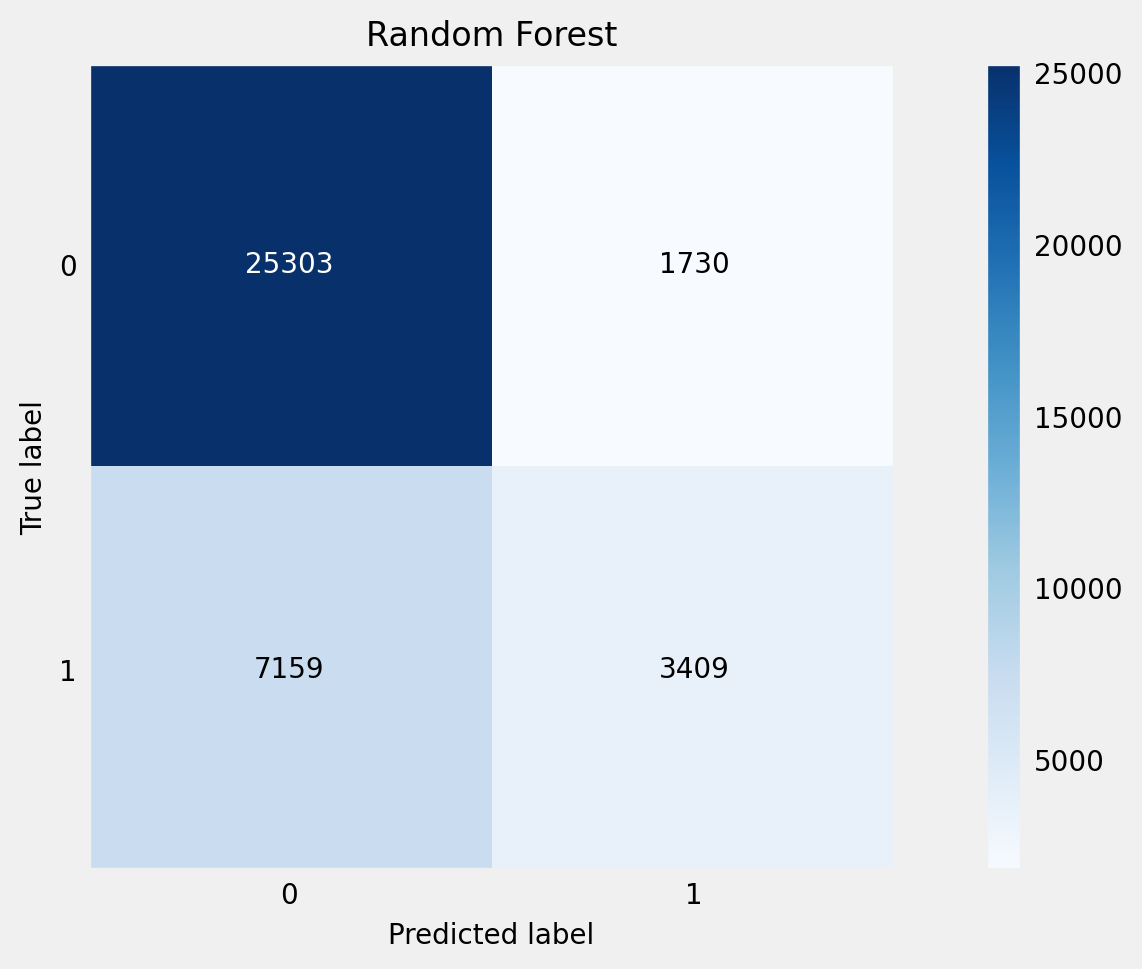

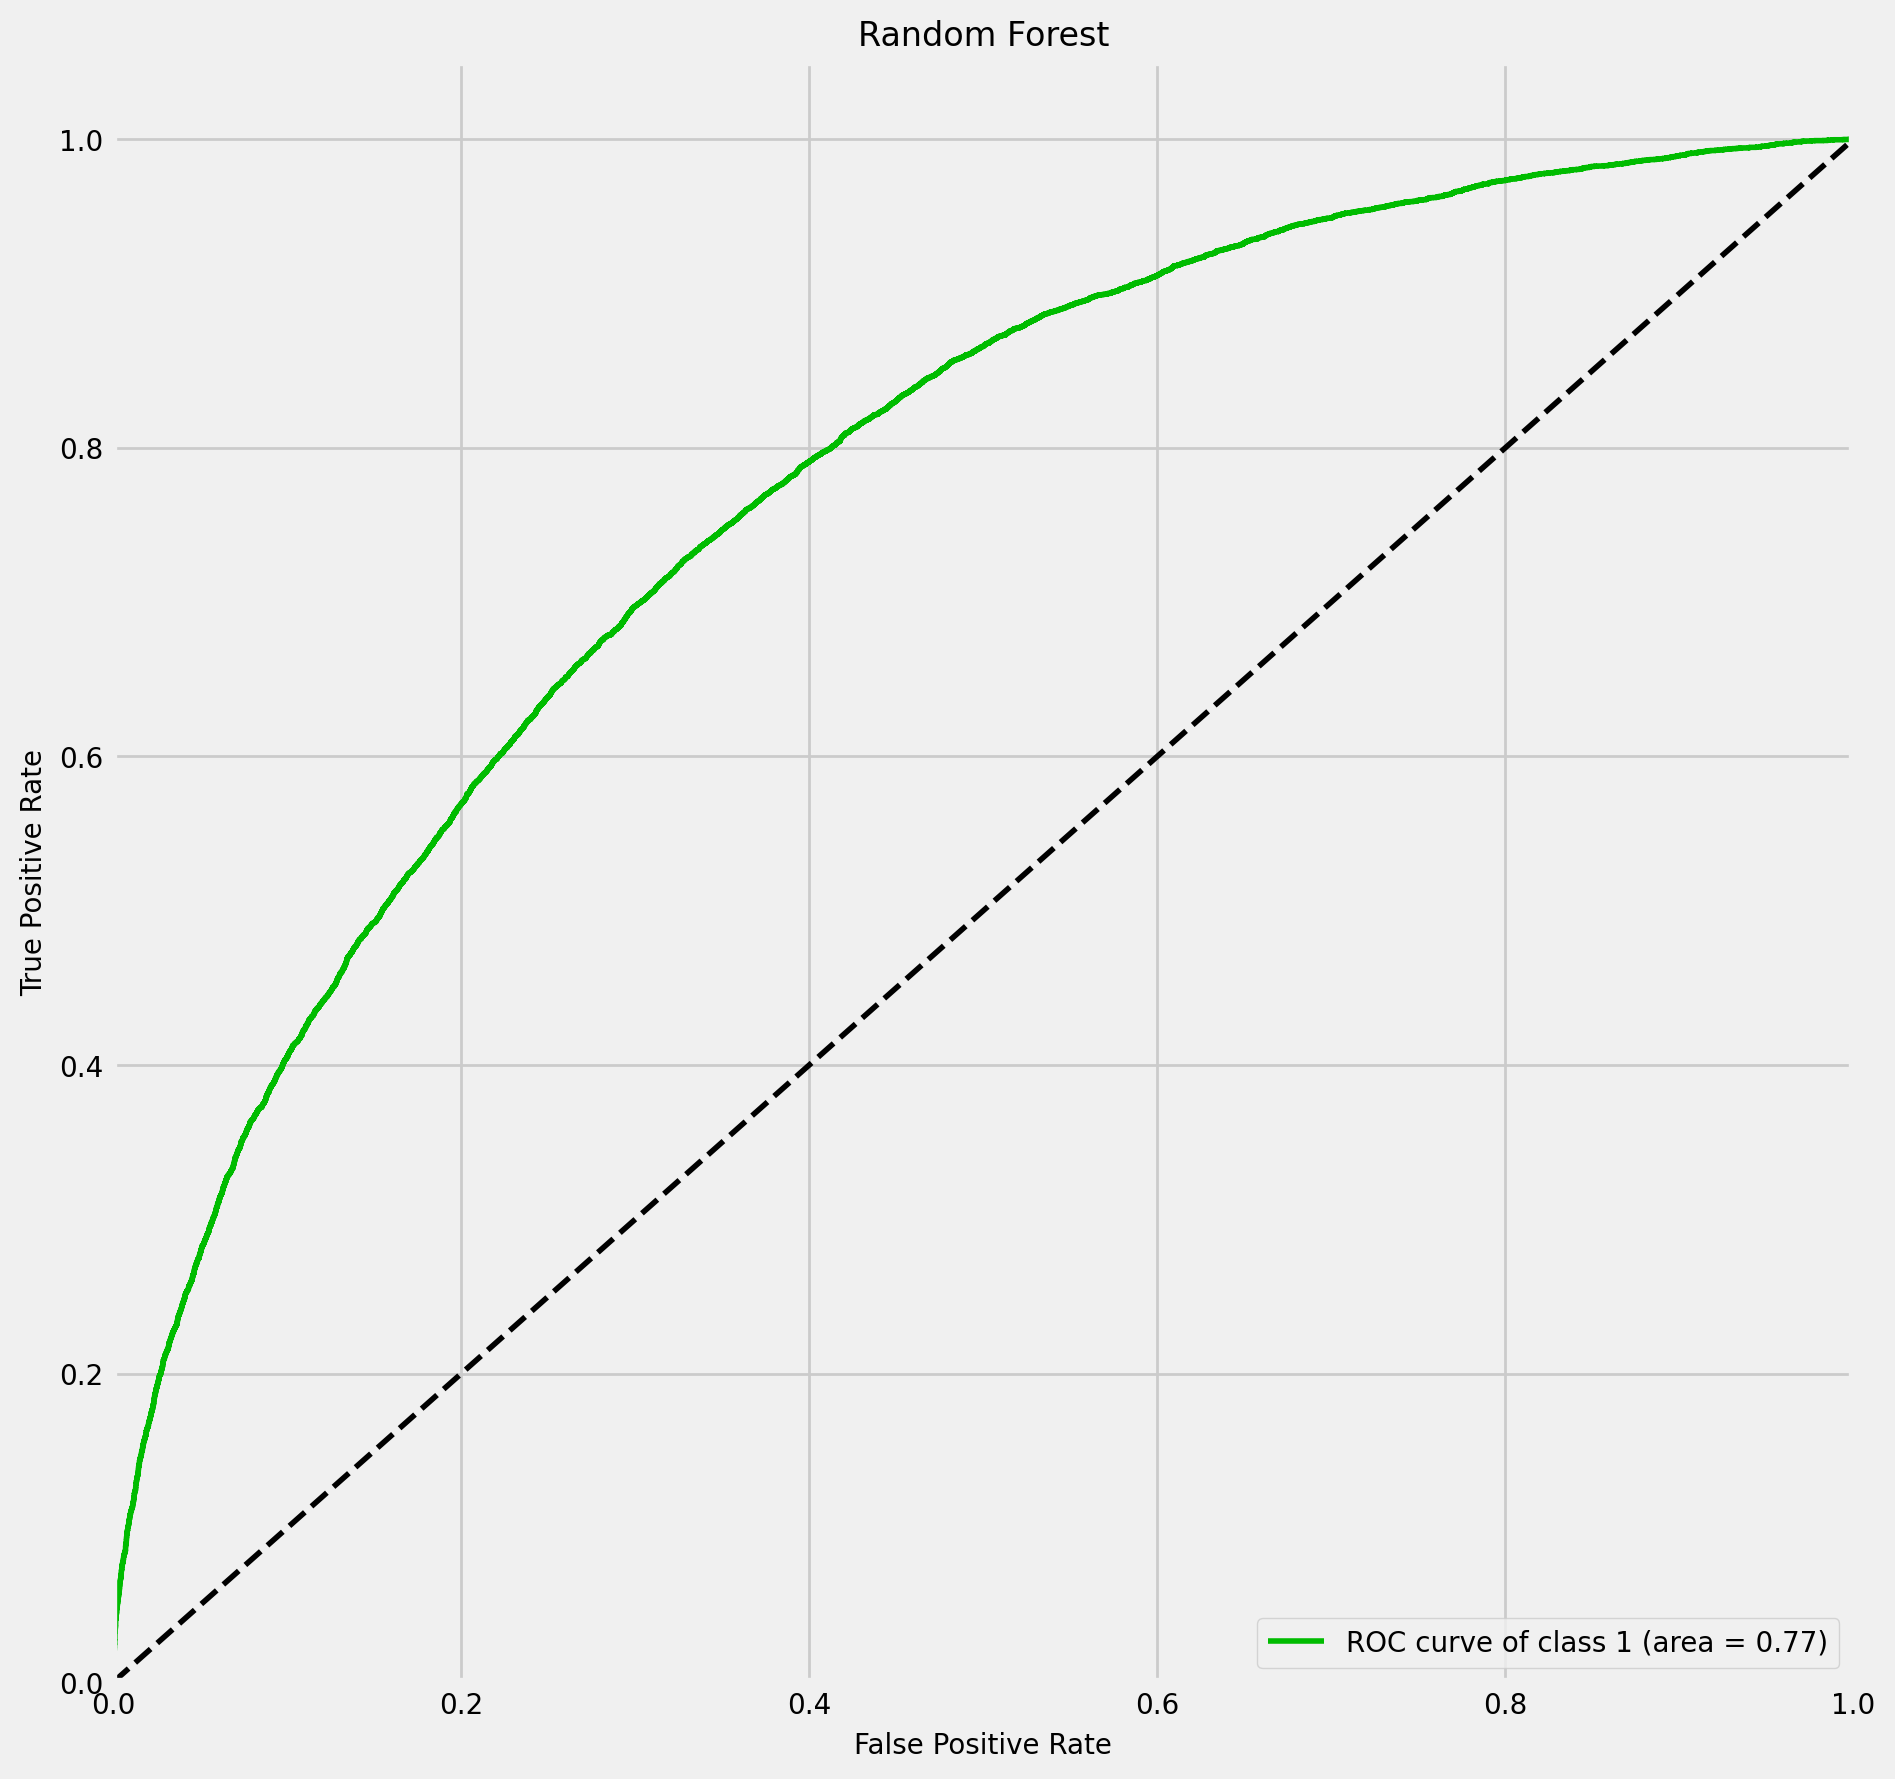

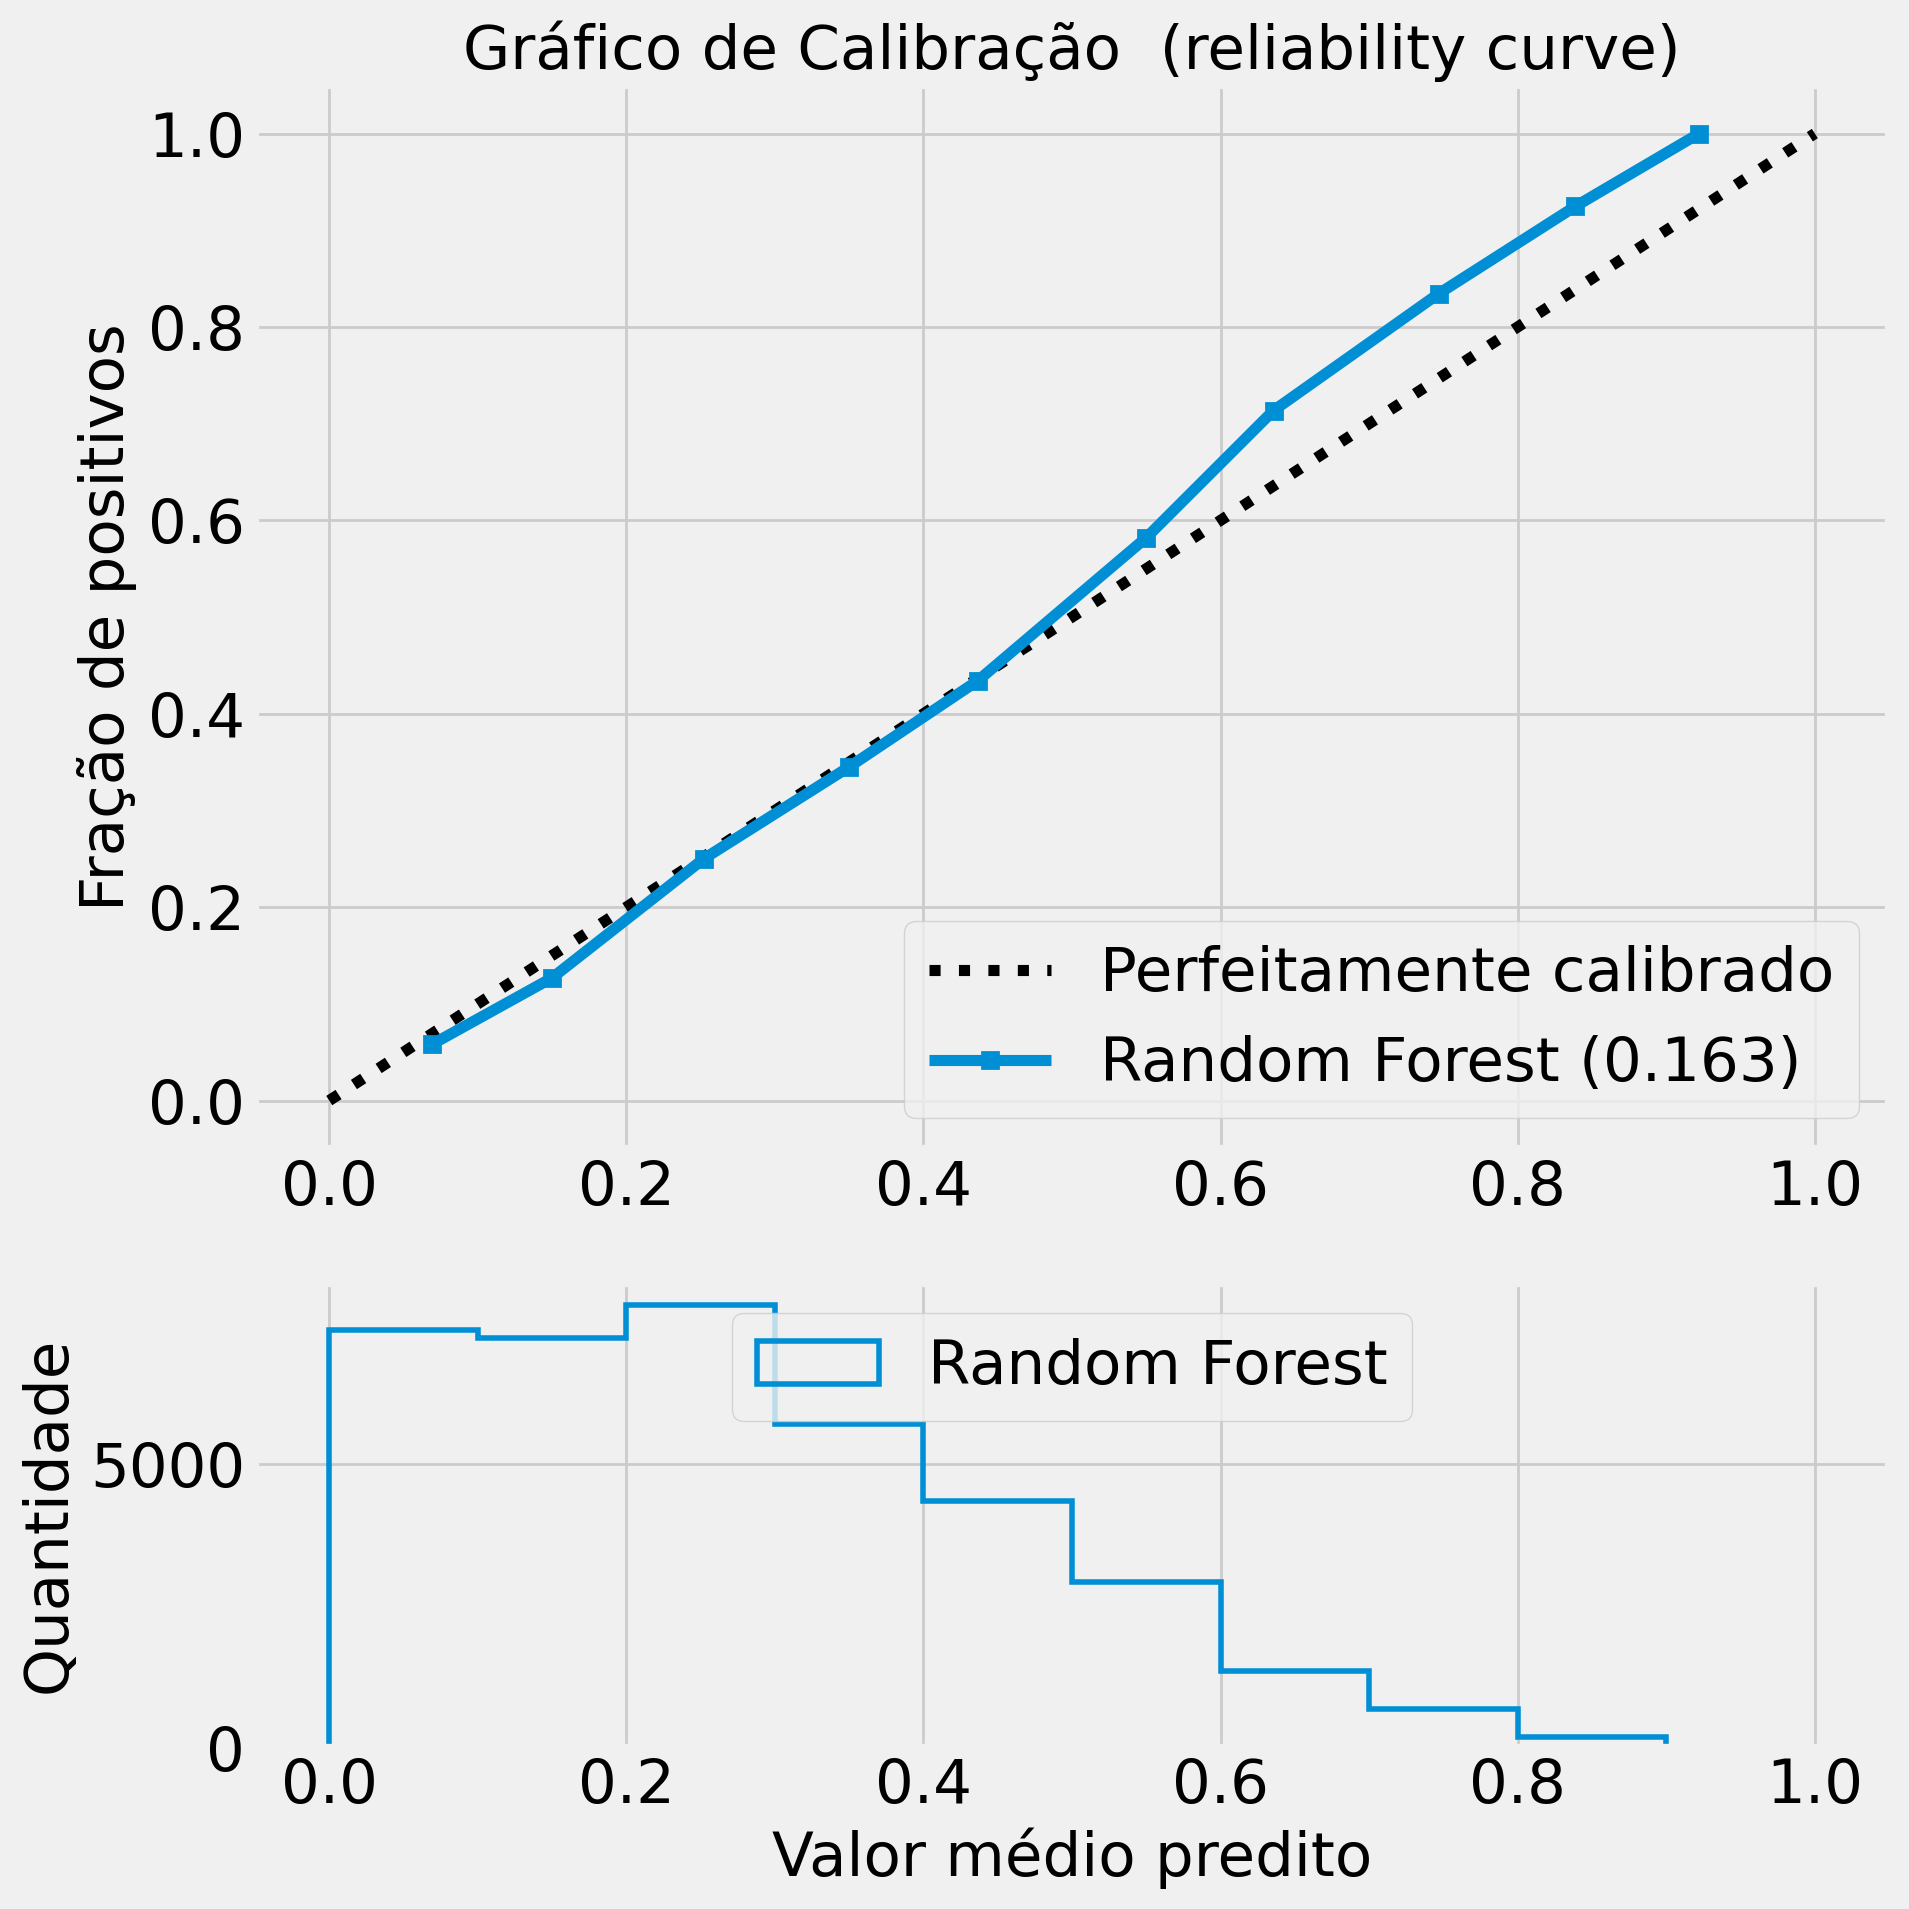

In [ ]:
# performance do modelo
runModel(rf, X_train, y_train, X_test, y_test, title="Random Forest")

**6.2 XGBOOST**

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier()

XGBoost:
	Brier: 0.164
	ROC(AUC) 0.769
	Precision: 0.628
	Recall: 0.360
	F1: 0.458



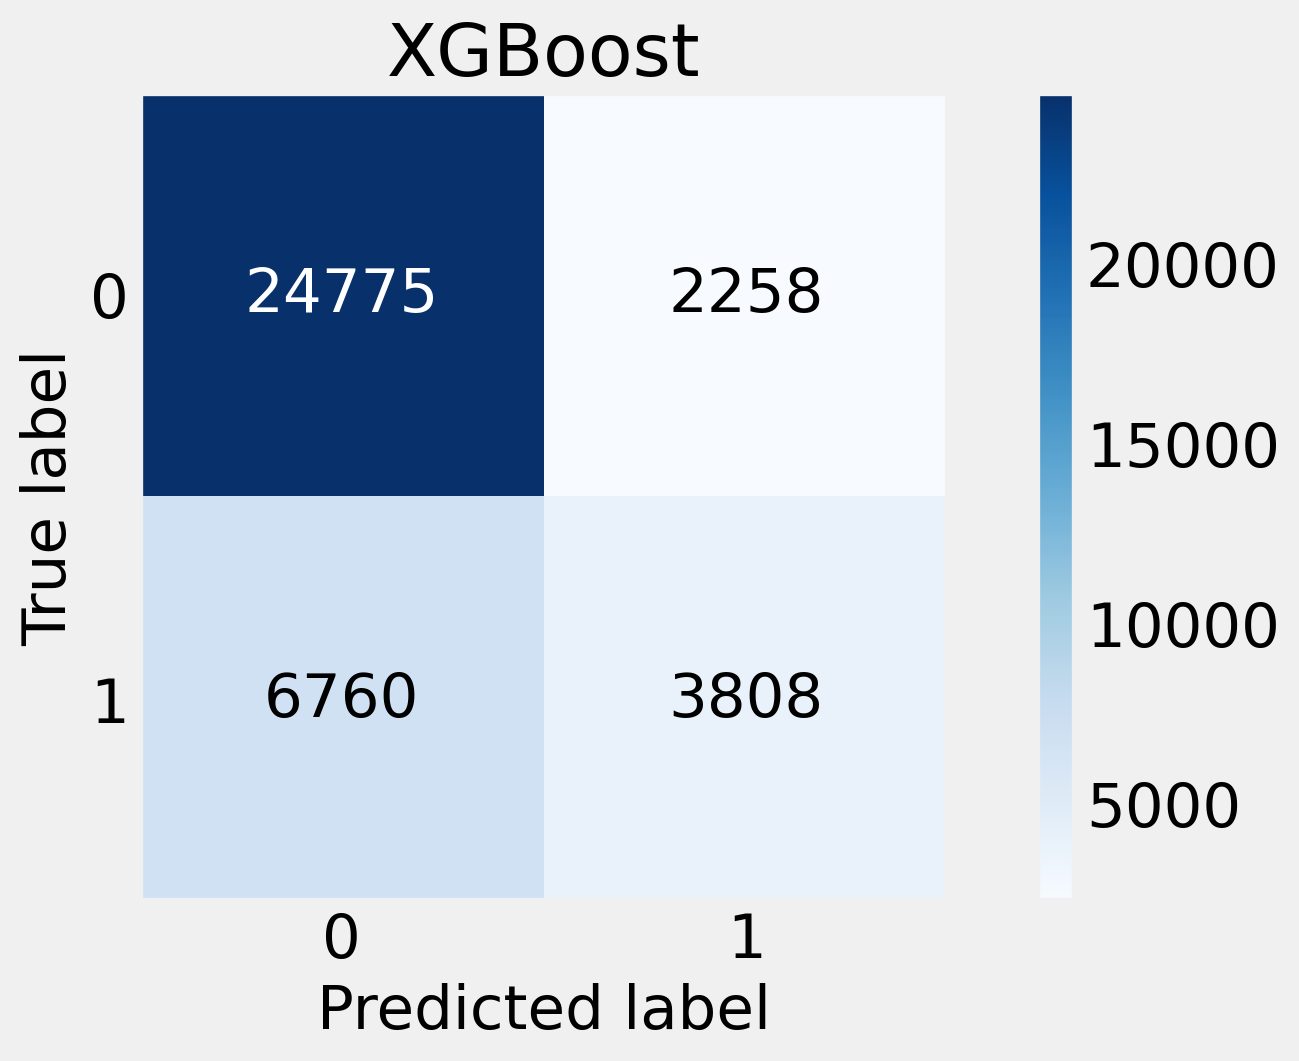

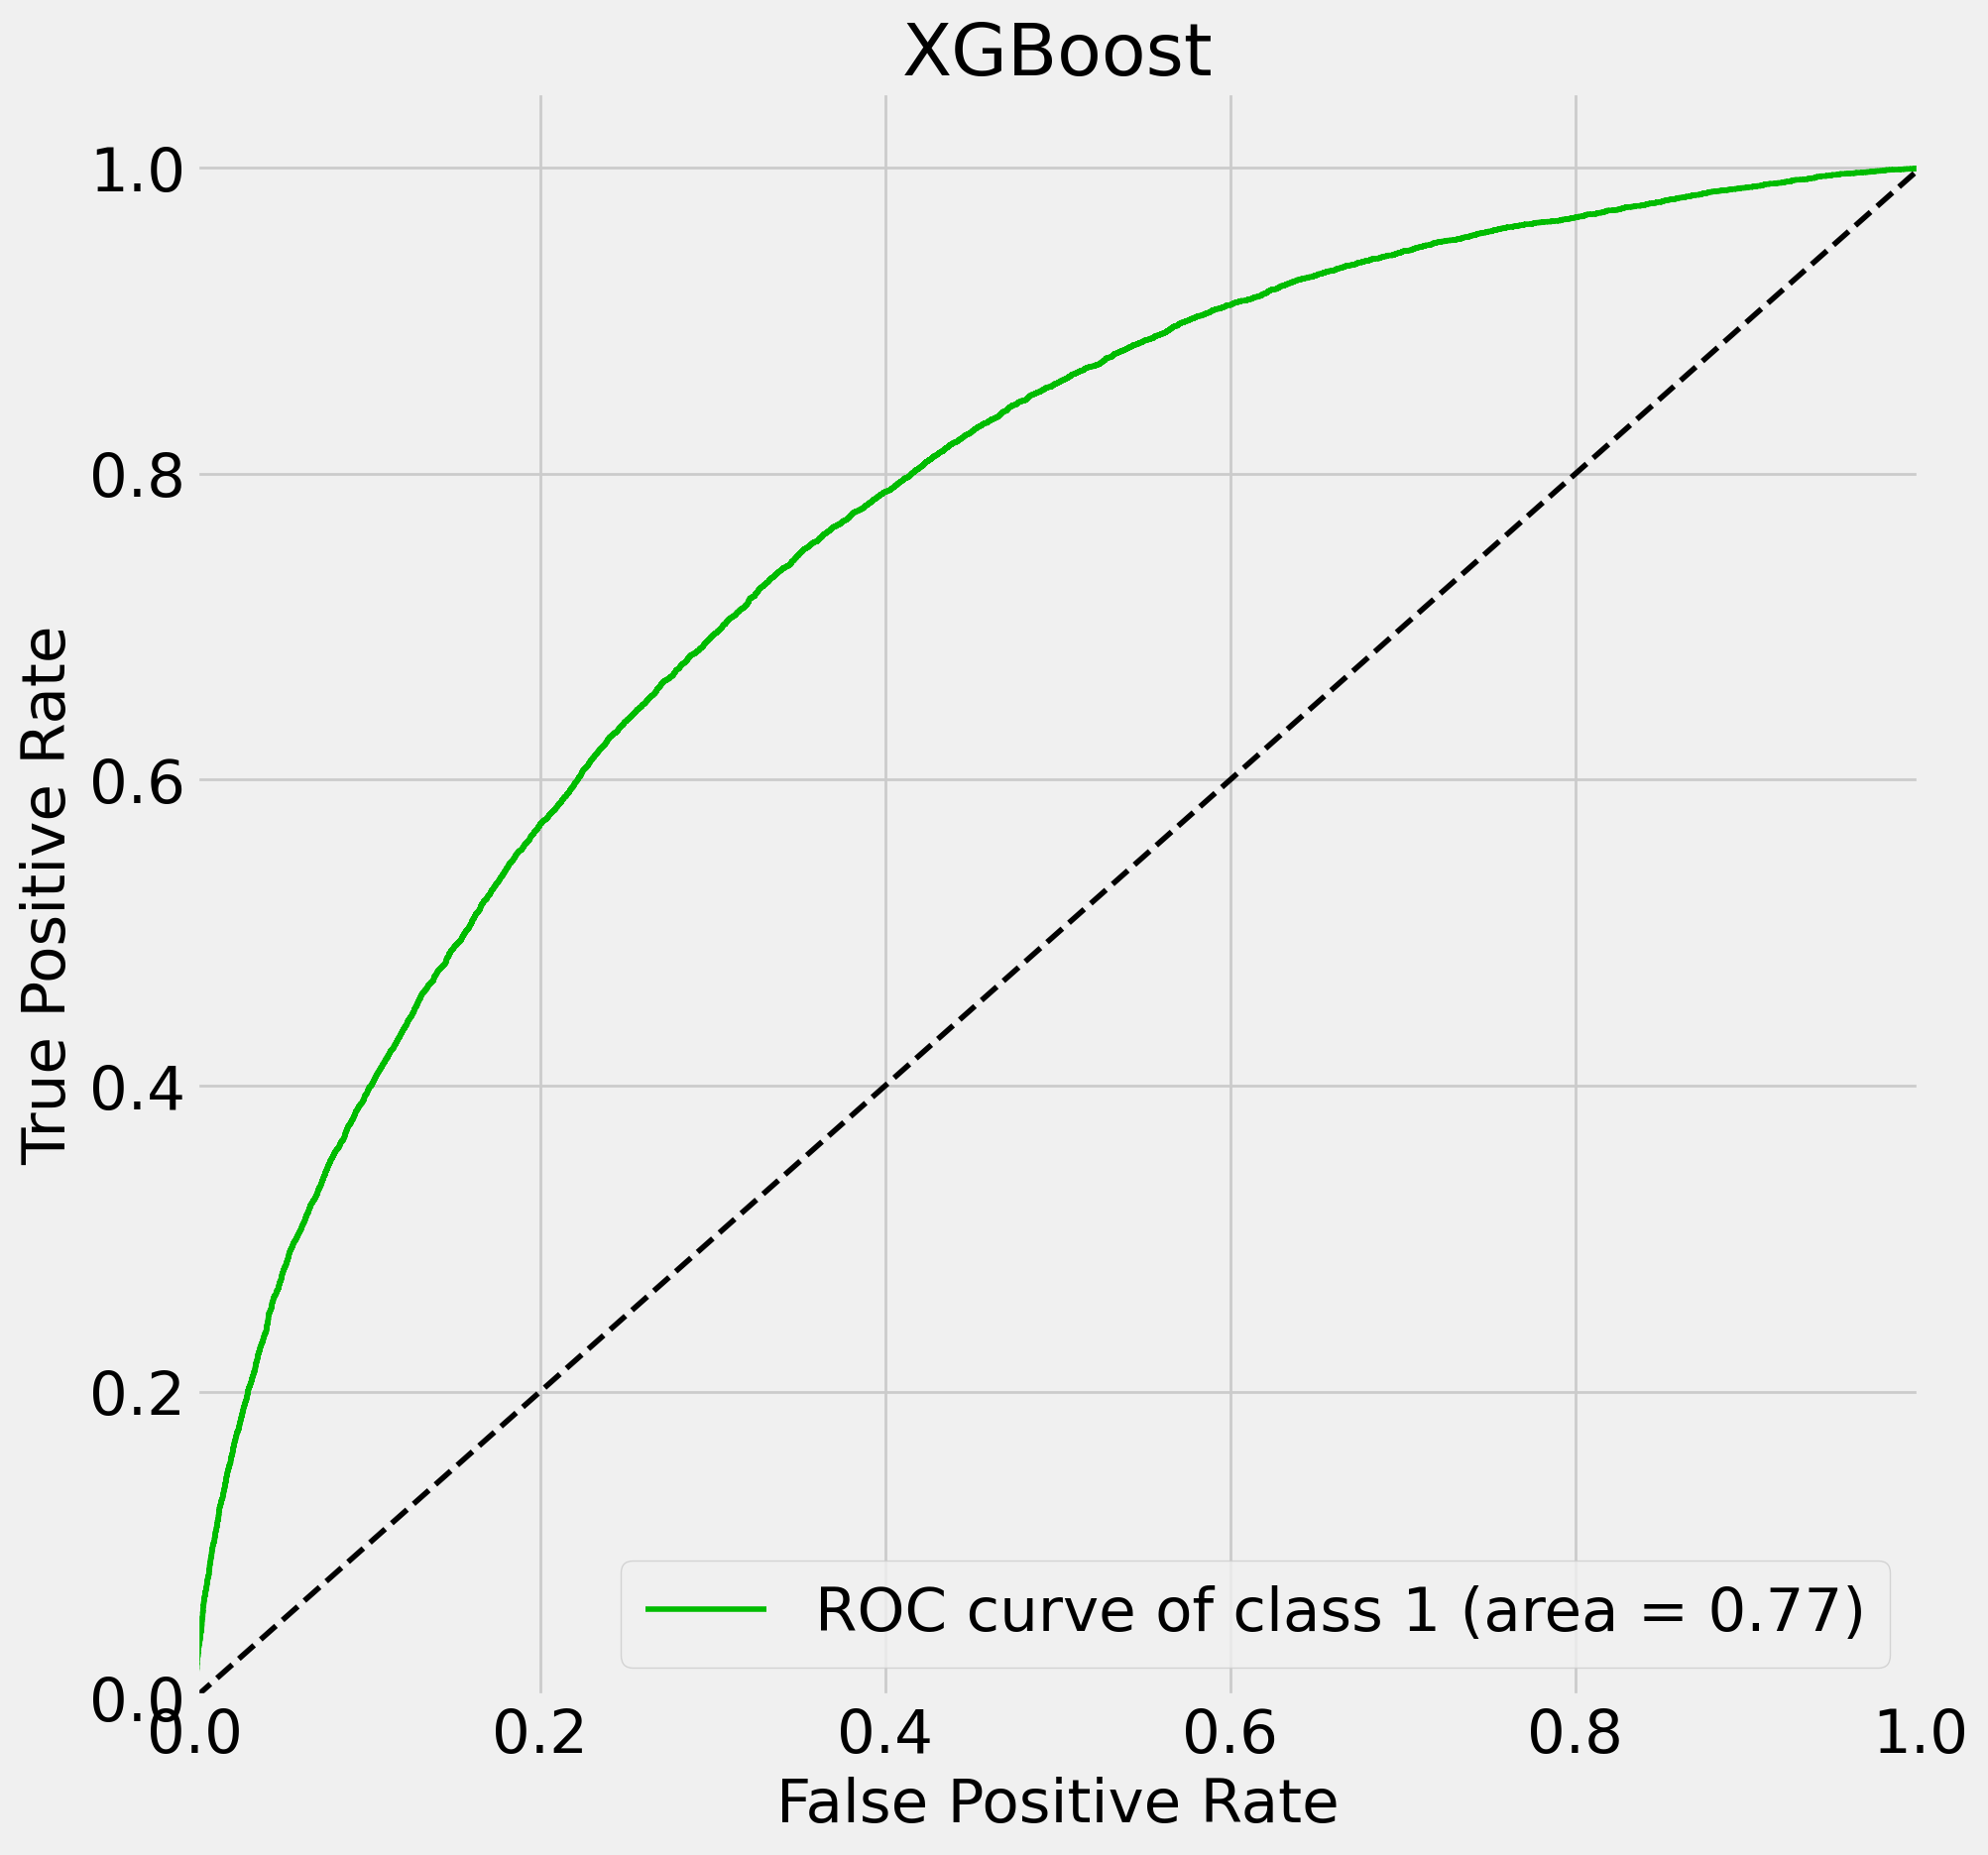

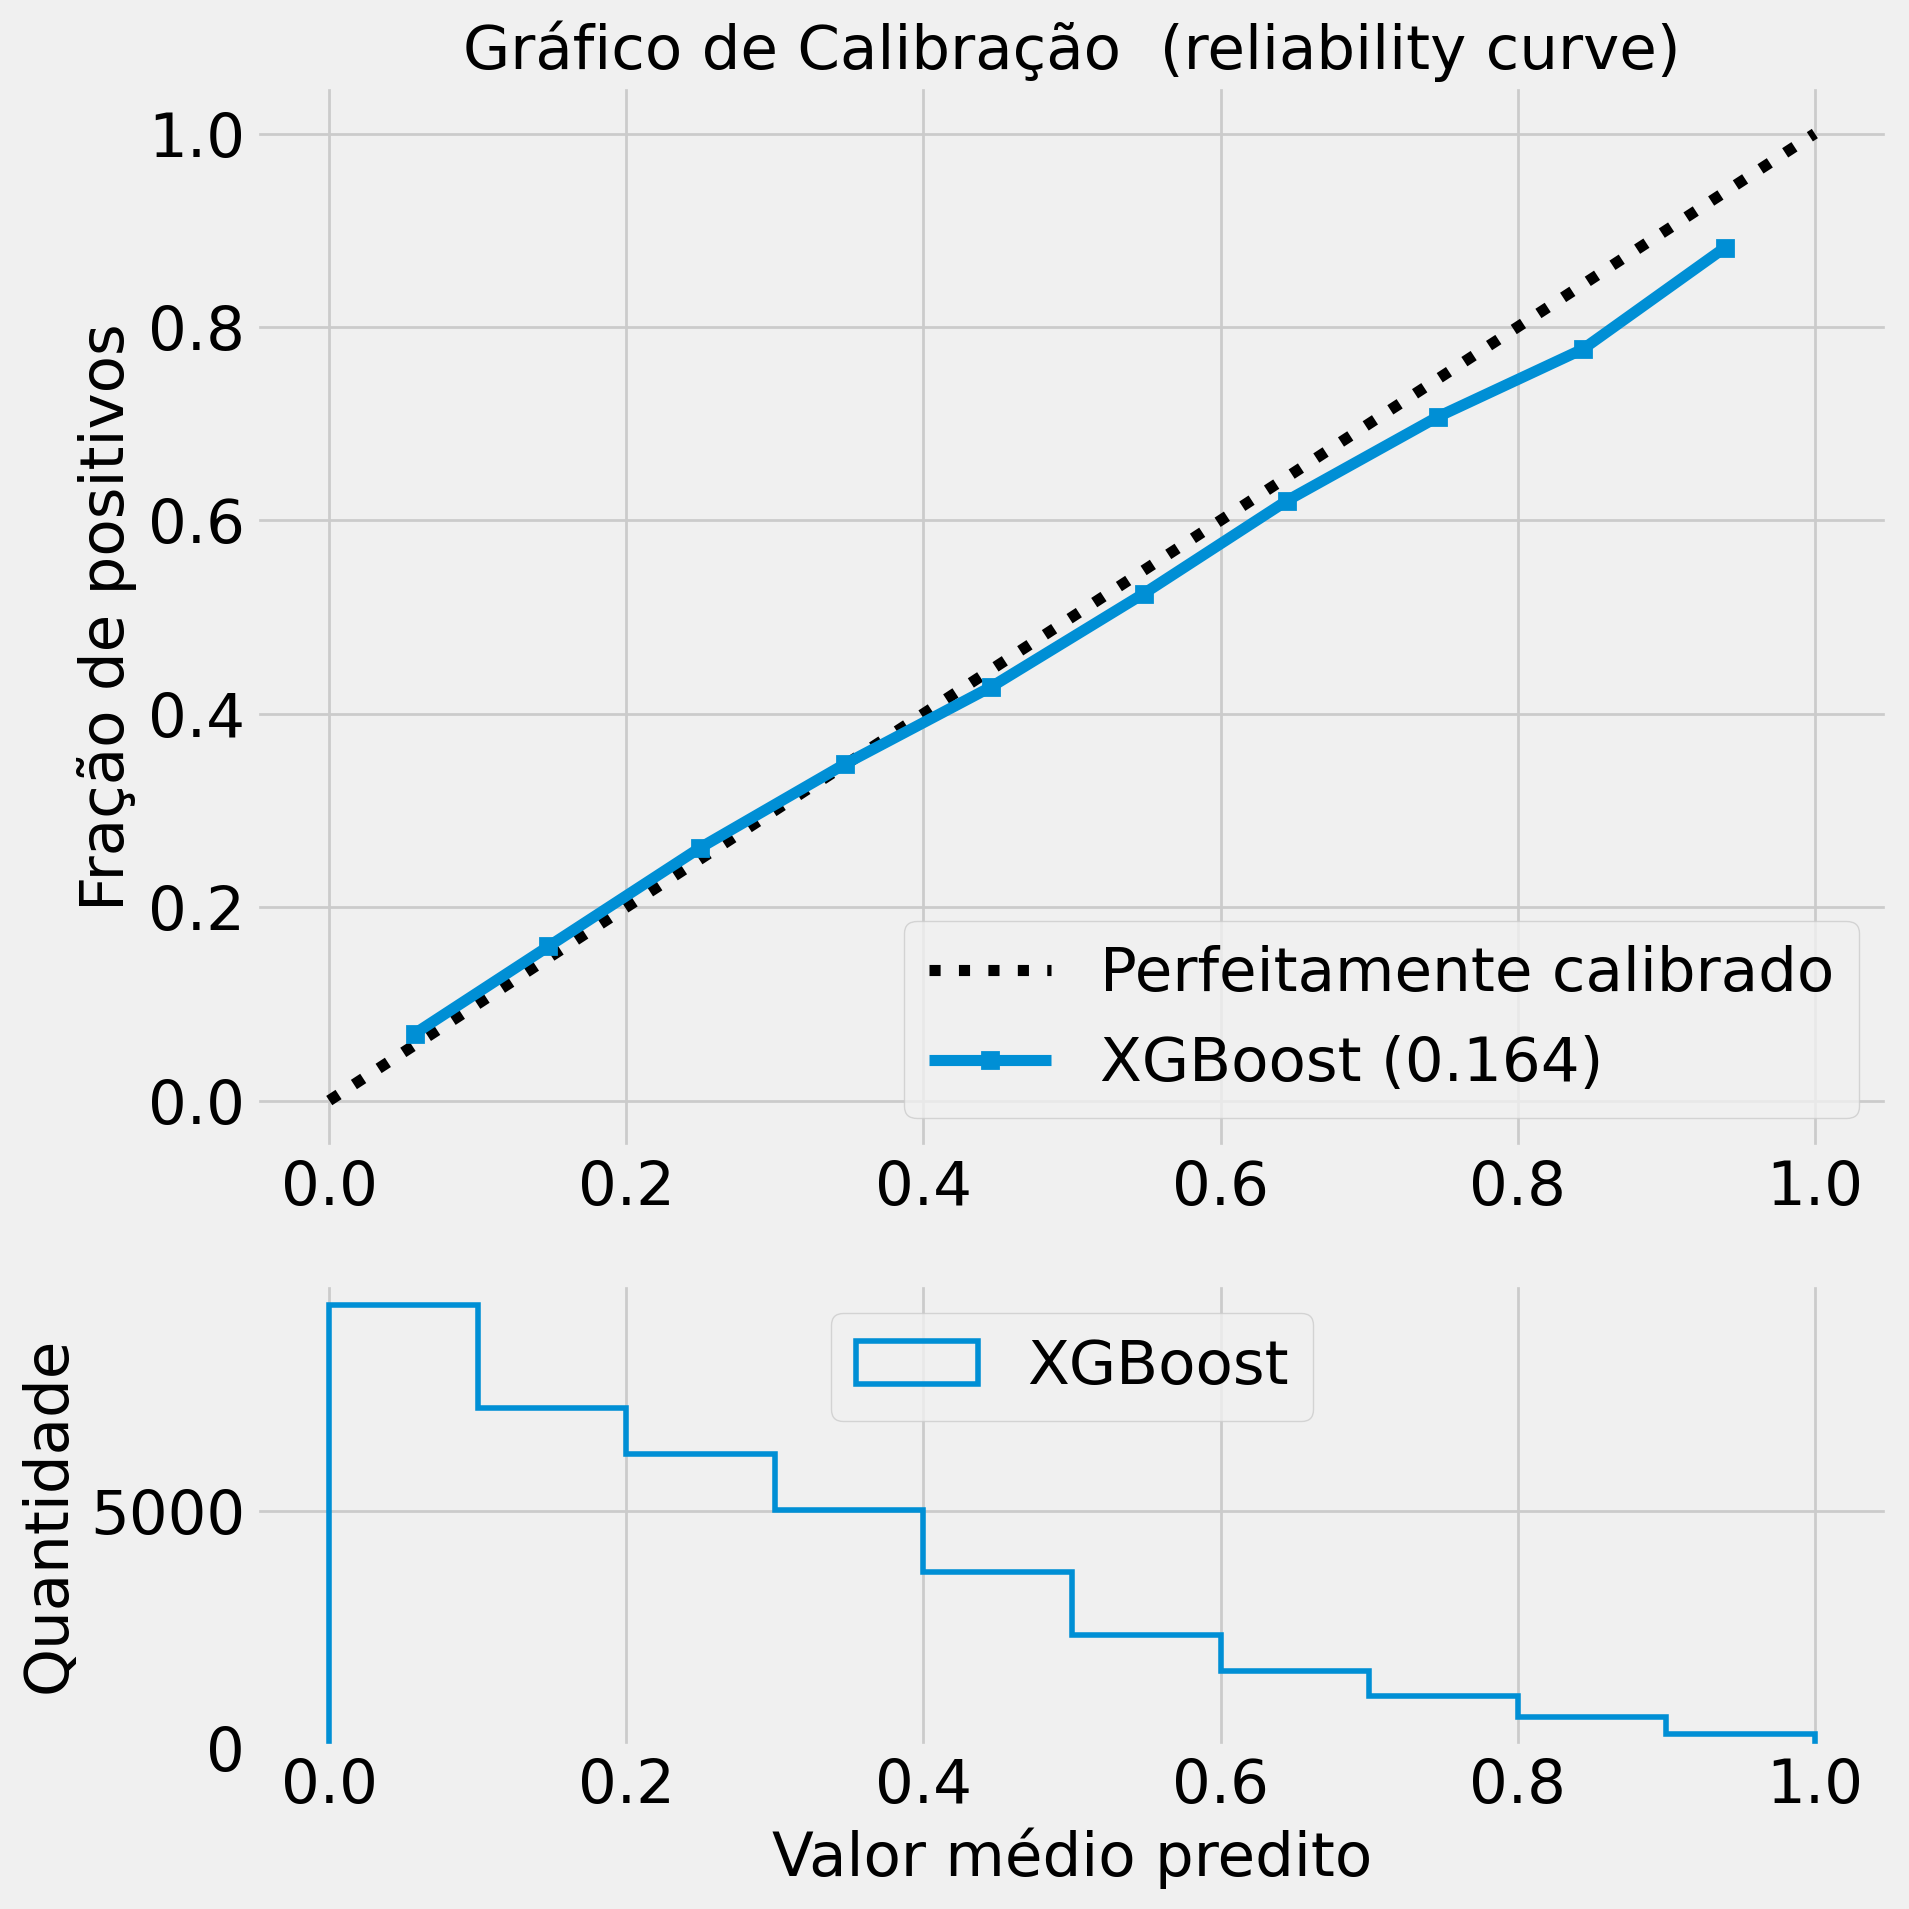

In [ ]:
runModel(model, X_train, y_train, X_test, y_test, title="XGBoost")

**6.3 LightGBM**

In [ ]:
import lightgbm as lgb

In [ ]:
clf_lgbm = lgb.LGBMClassifier()

[LightGBM] [Info] Number of positive: 24659, number of negative: 63075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 87734, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281065 -> initscore=-0.939183
[LightGBM] [Info] Start training from score -0.939183
LightGBM:
	Brier: 0.161
	ROC(AUC) 0.776
	Precision: 0.641
	Recall: 0.366
	F1: 0.466



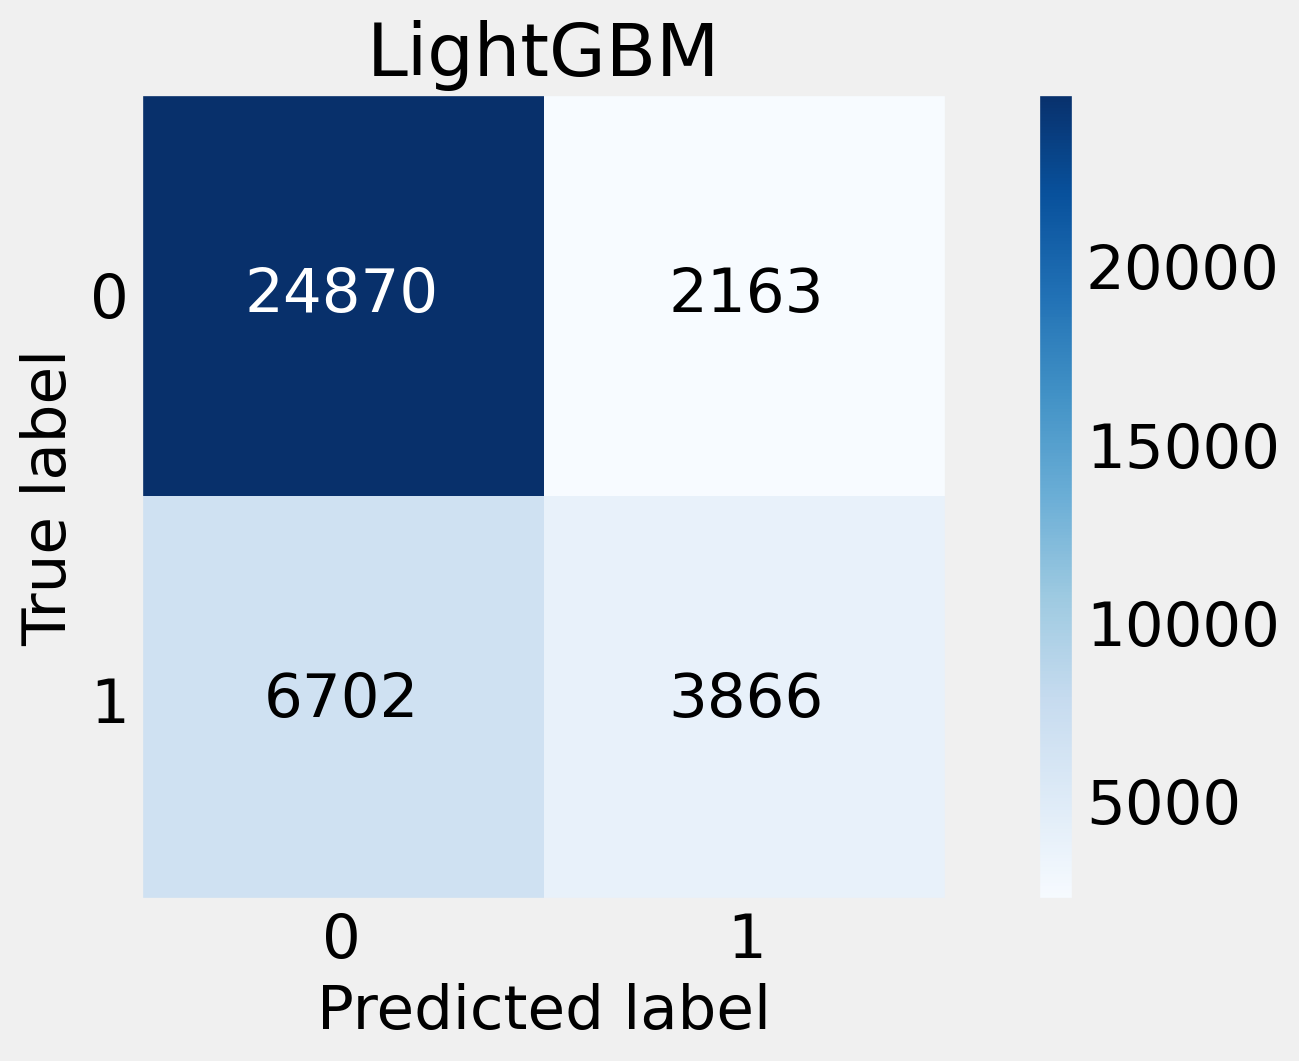

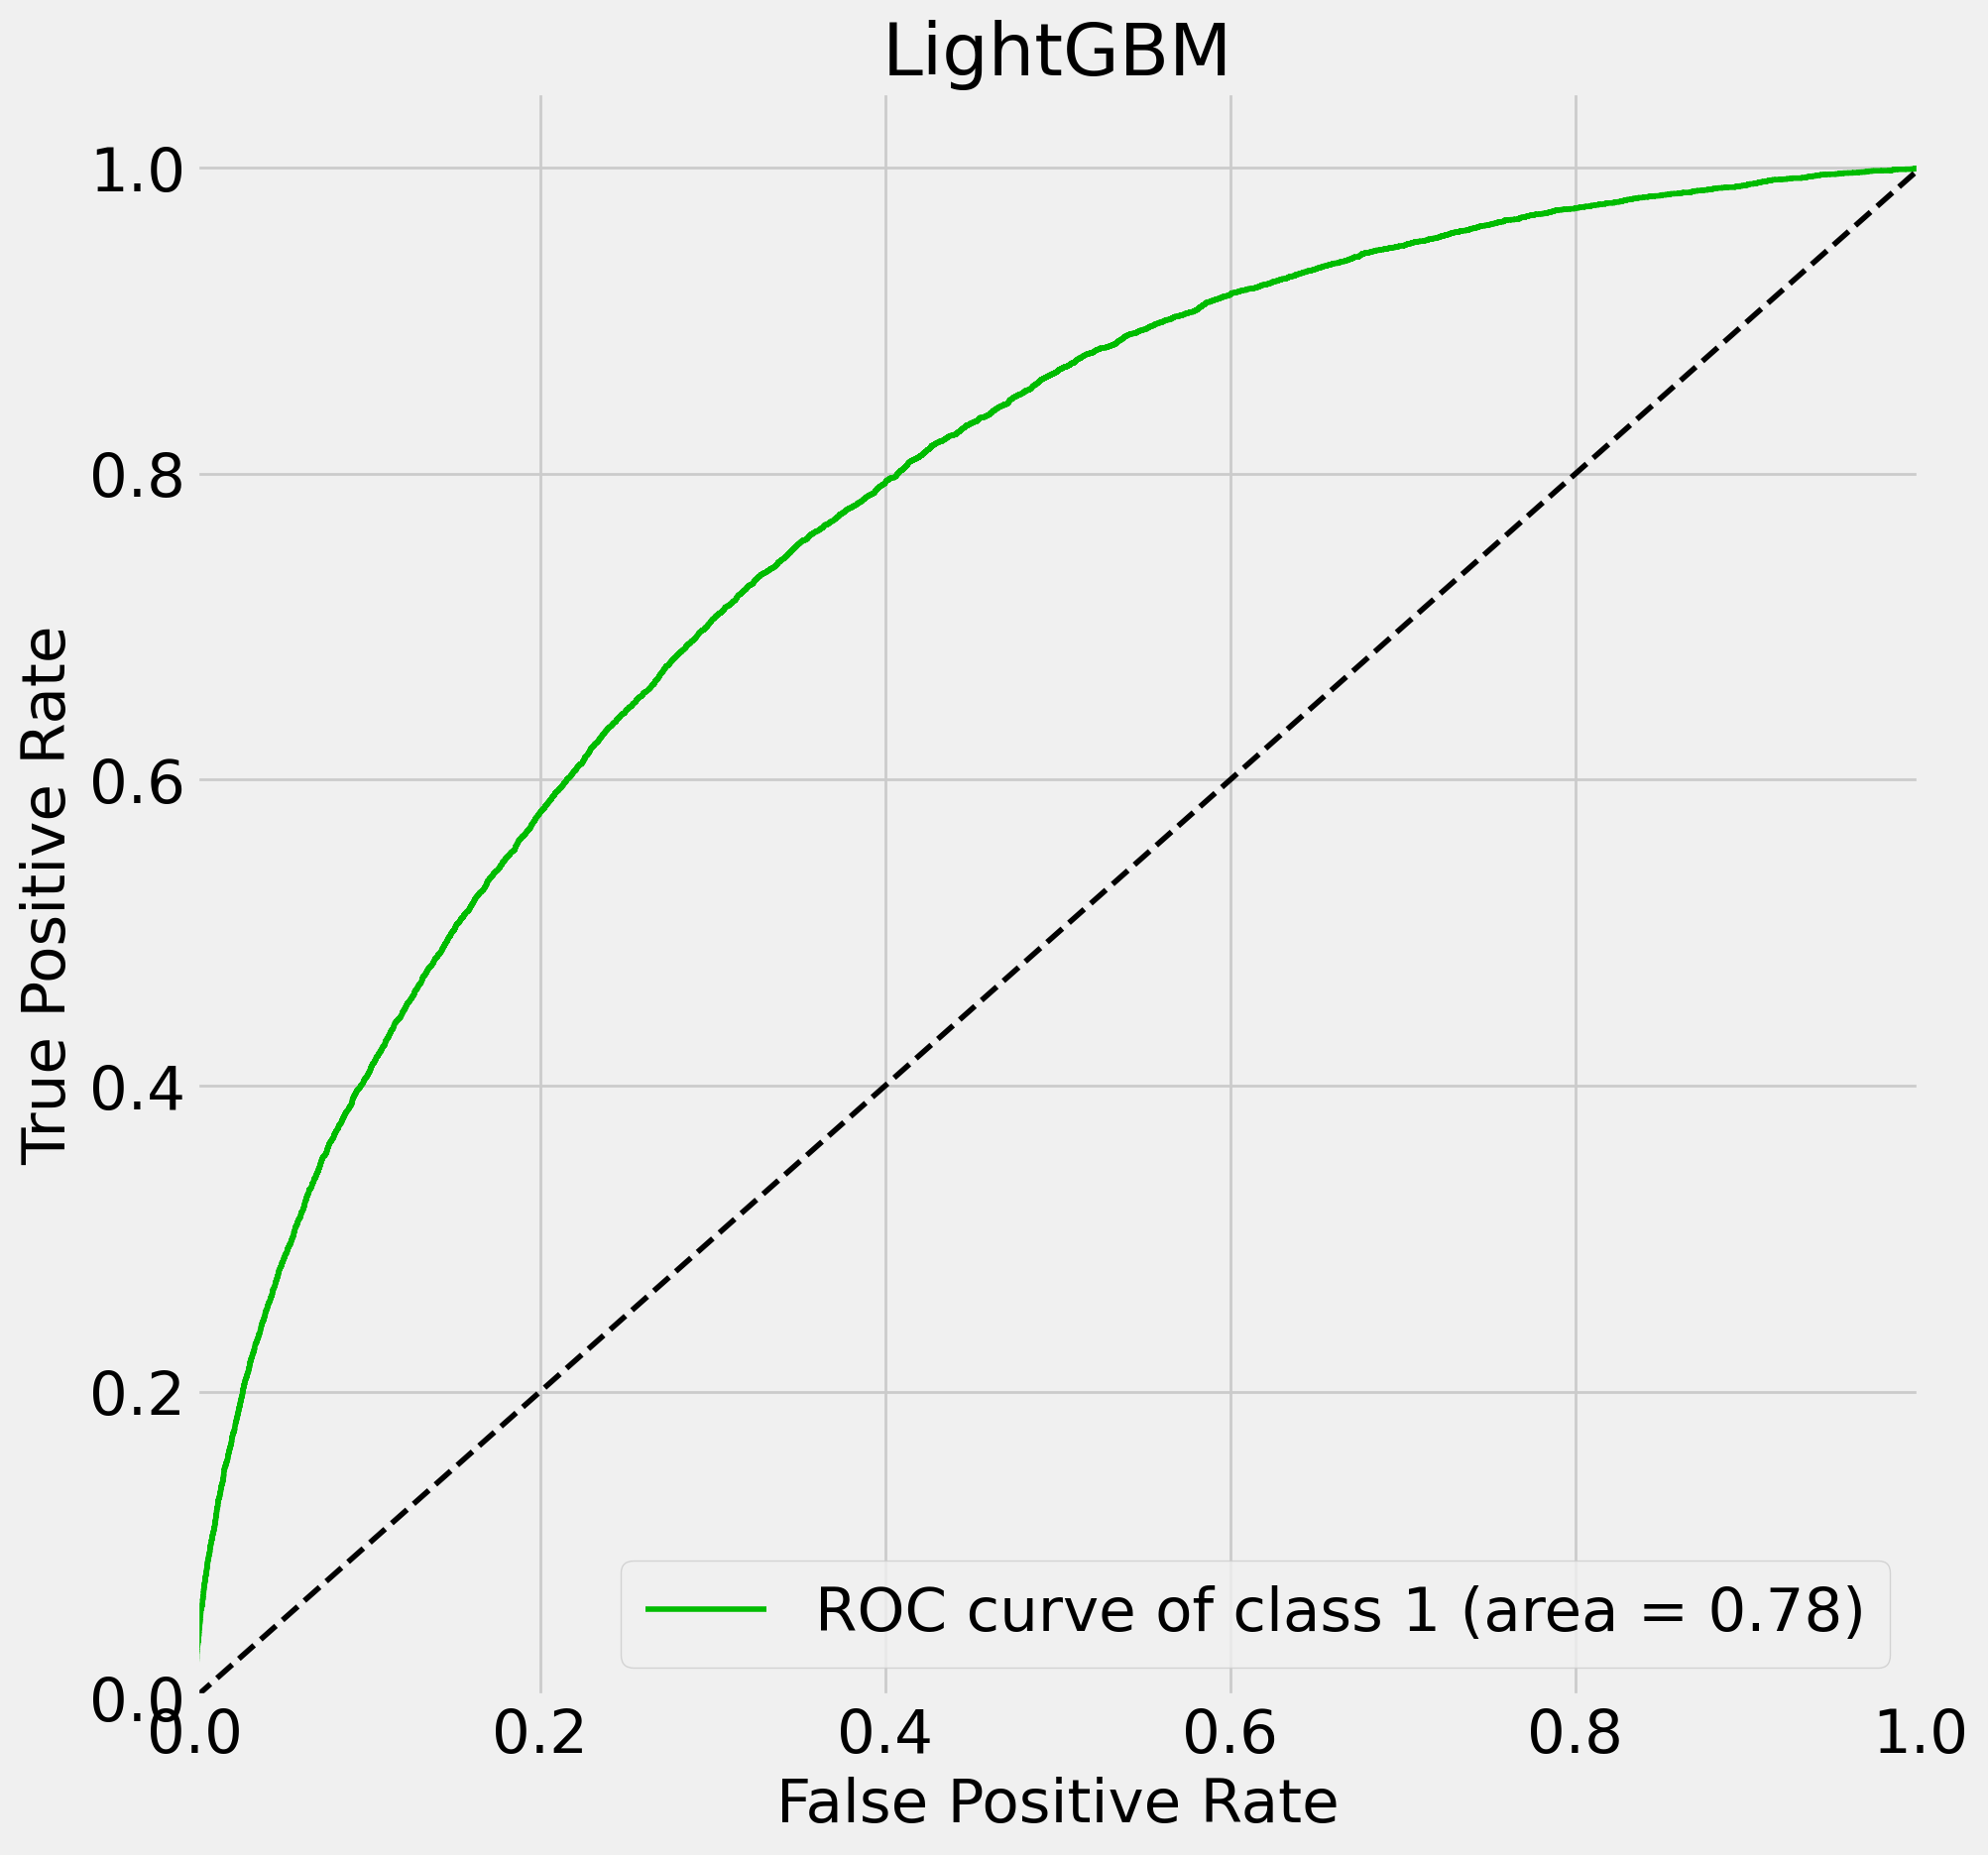

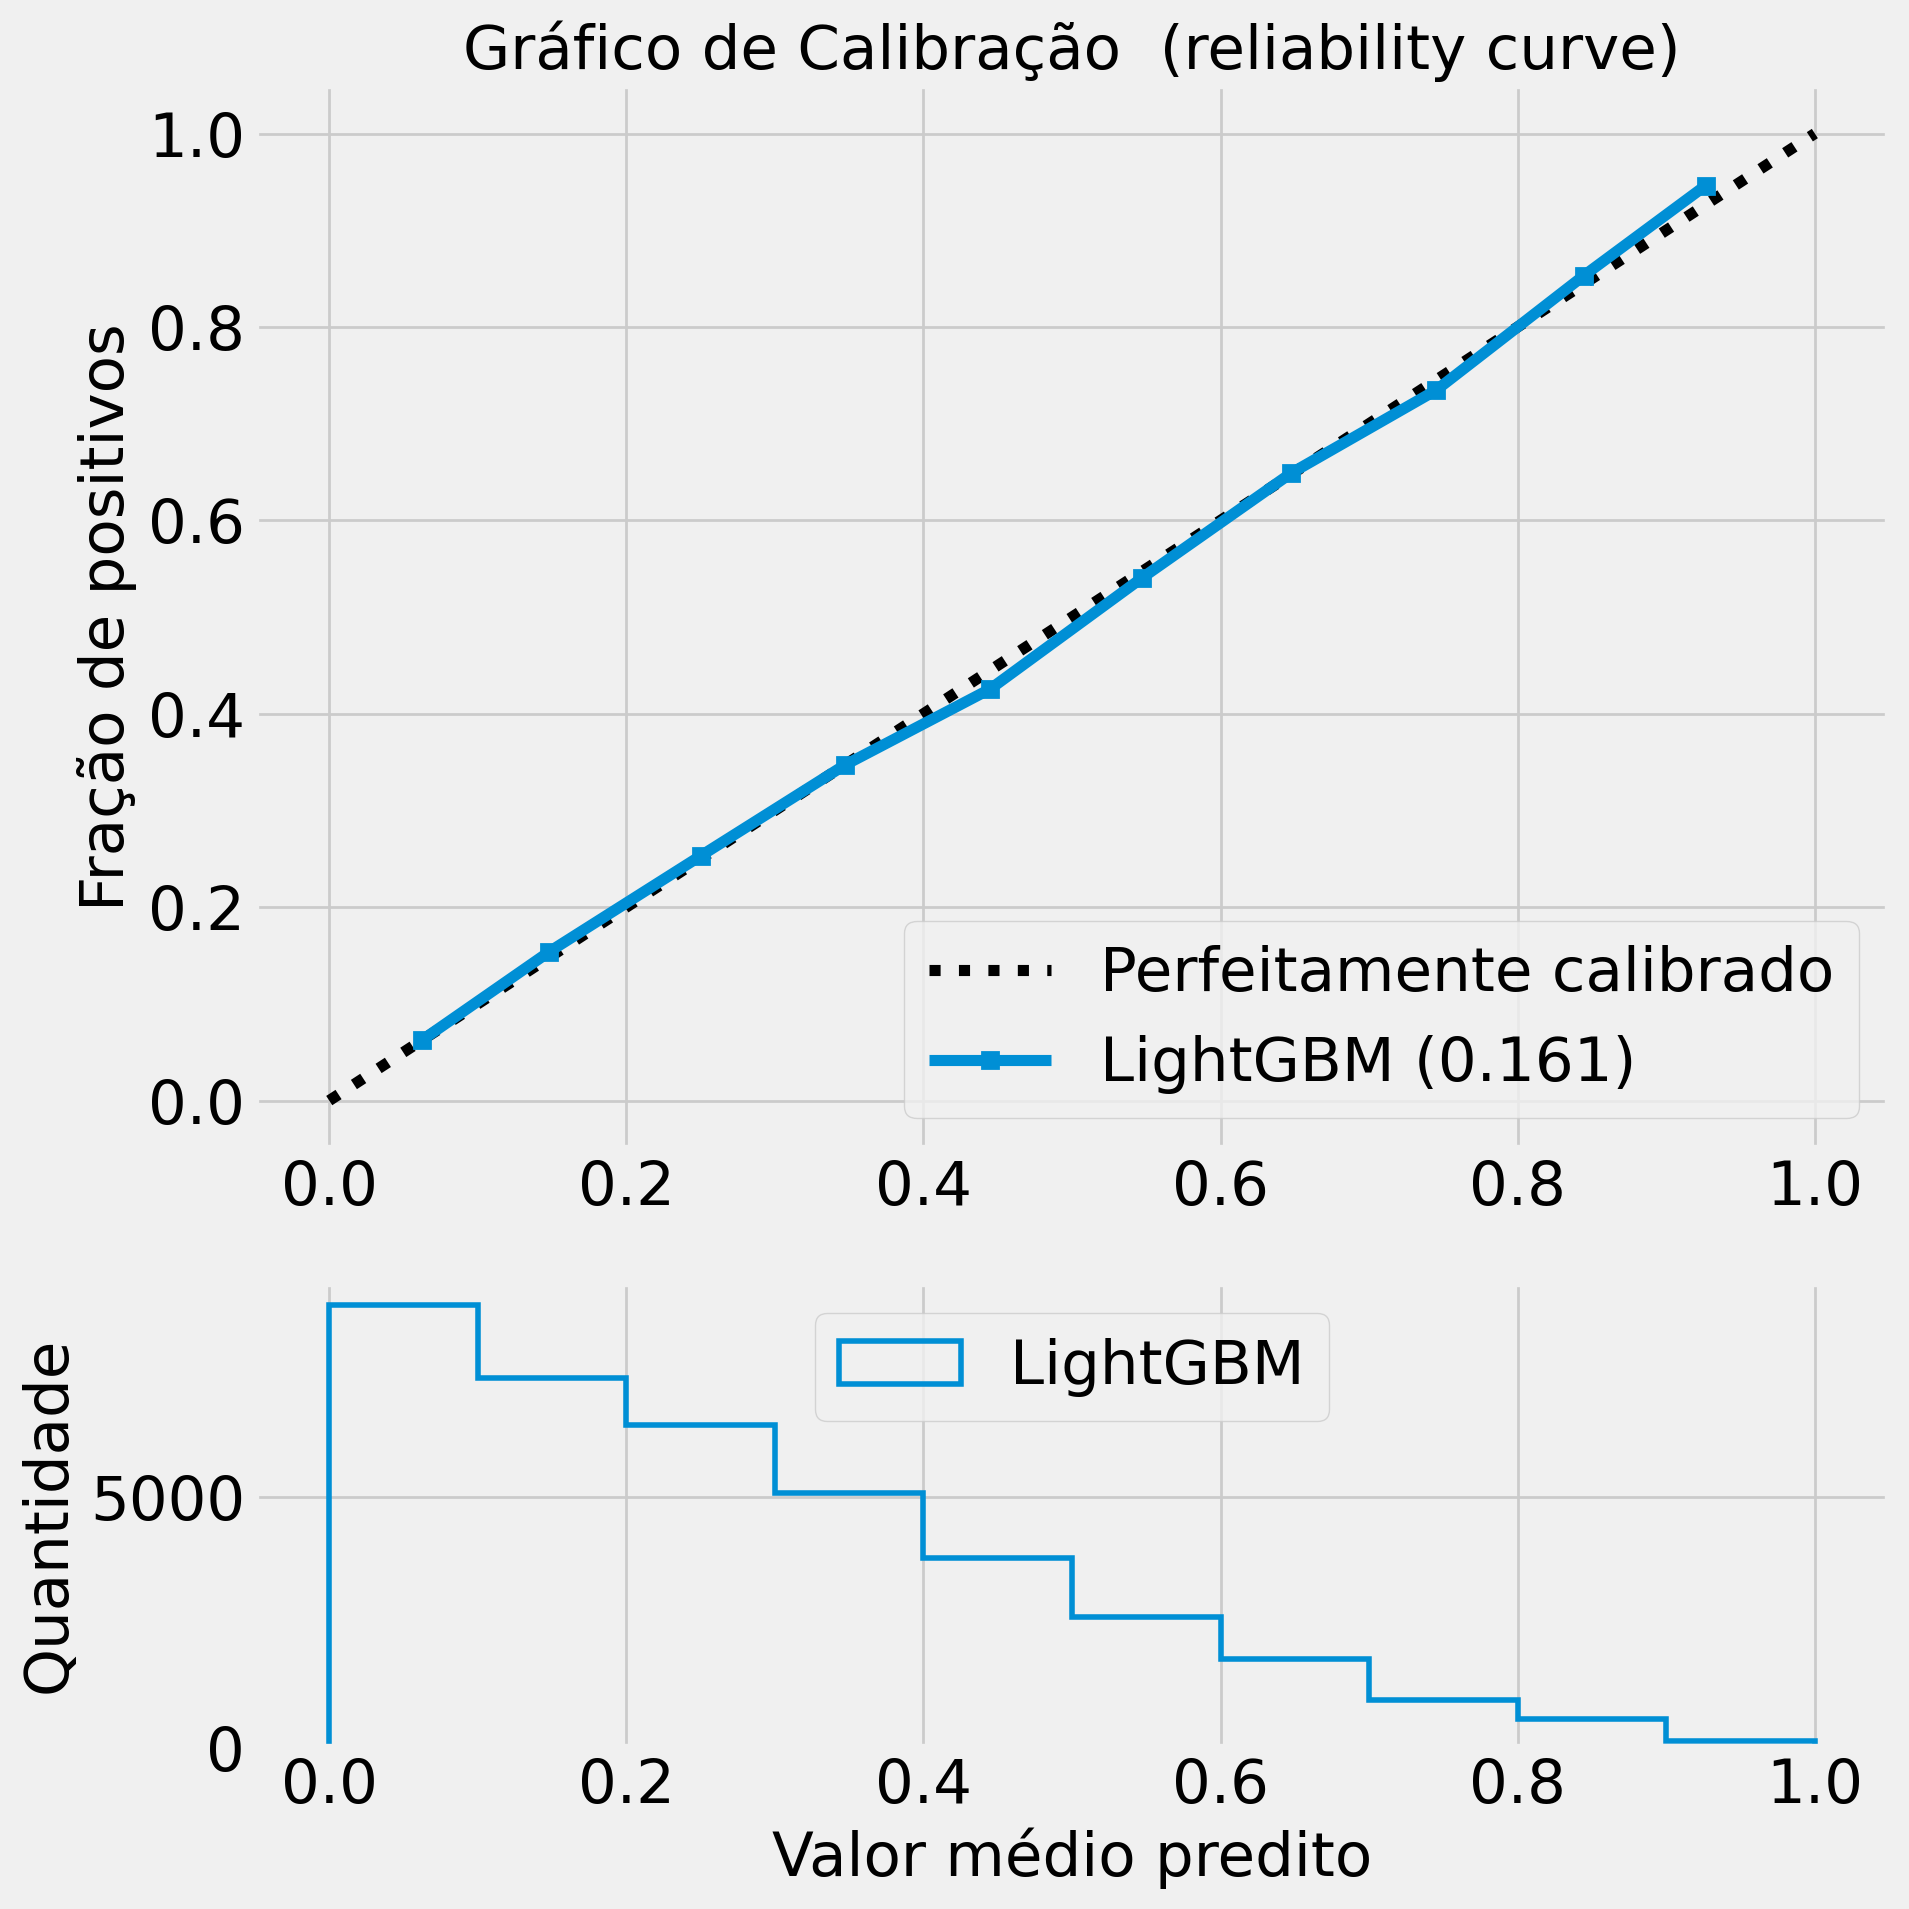

In [ ]:
runModel(clf_lgbm, X_train, y_train, X_test, y_test, title="LightGBM")

**6.4 Catboost**

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.6 MB/s eta 0:00:00


In [ ]:
clf_catboost = CatBoostClassifier()

Learning rate set to 0.069609
0:	learn: 0.6634049	total: 98.3ms	remaining: 1m 38s
1:	learn: 0.6376514	total: 143ms	remaining: 1m 11s
2:	learn: 0.6165418	total: 184ms	remaining: 1m 1s
3:	learn: 0.5978831	total: 235ms	remaining: 58.5s
4:	learn: 0.5824821	total: 280ms	remaining: 55.7s
5:	learn: 0.5698983	total: 327ms	remaining: 54.2s
6:	learn: 0.5586565	total: 374ms	remaining: 53.1s
7:	learn: 0.5492091	total: 420ms	remaining: 52.1s
8:	learn: 0.5414763	total: 474ms	remaining: 52.2s
9:	learn: 0.5346361	total: 523ms	remaining: 51.7s
10:	learn: 0.5287331	total: 562ms	remaining: 50.5s
11:	learn: 0.5237710	total: 598ms	remaining: 49.2s
12:	learn: 0.5197868	total: 616ms	remaining: 46.8s
13:	learn: 0.5159937	total: 634ms	remaining: 44.7s
14:	learn: 0.5130789	total: 653ms	remaining: 42.9s
15:	learn: 0.5102526	total: 670ms	remaining: 41.2s
16:	learn: 0.5082290	total: 691ms	remaining: 40s
17:	learn: 0.5059218	total: 710ms	remaining: 38.8s
18:	learn: 0.5039334	total: 728ms	remaining: 37.6s
19:	learn:

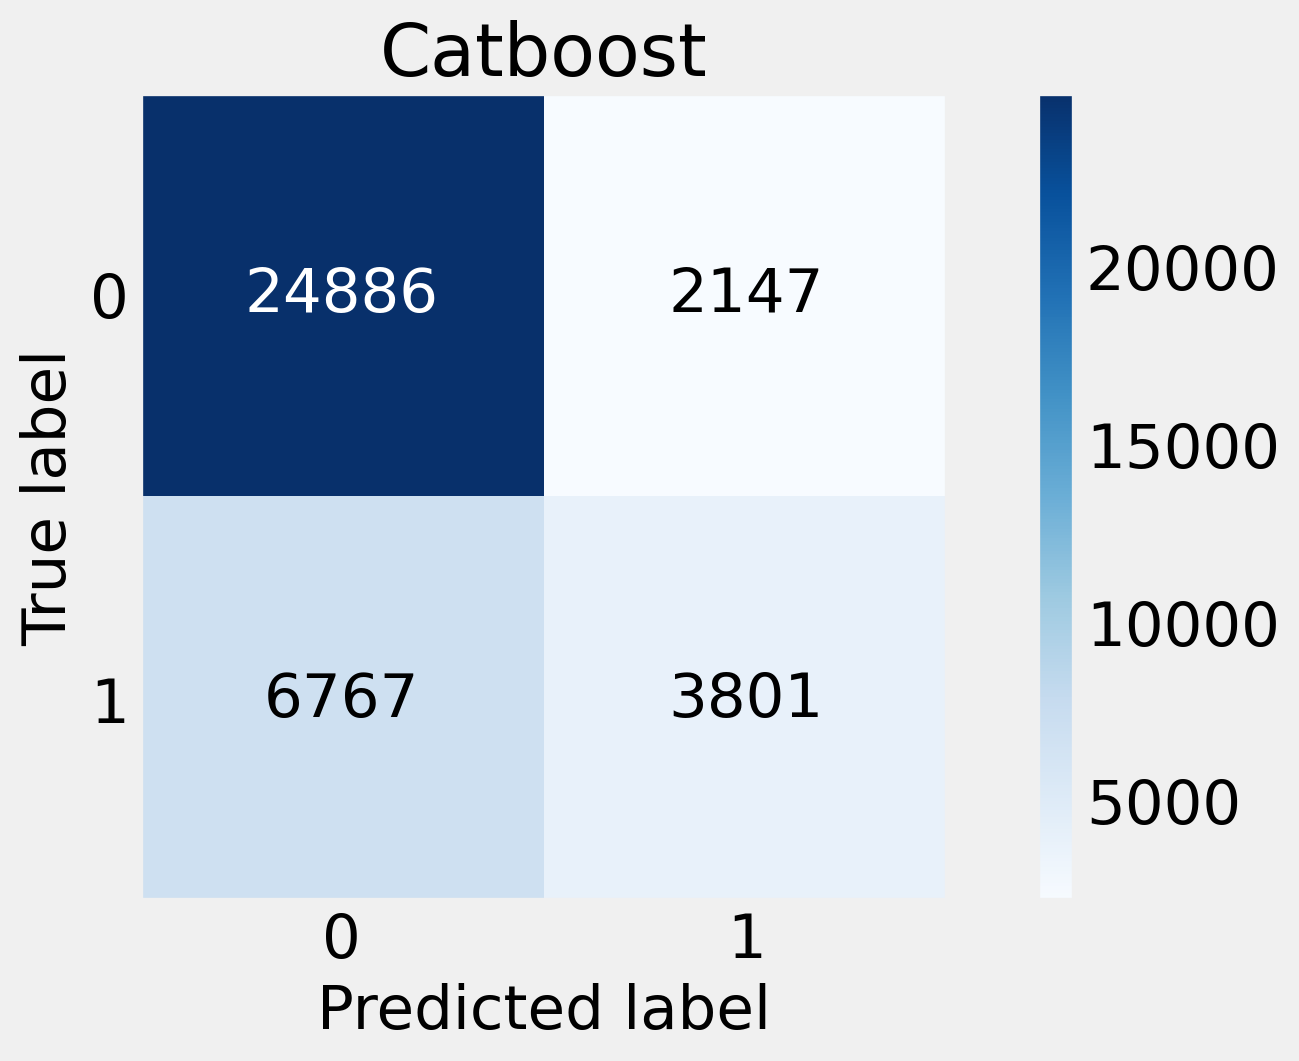

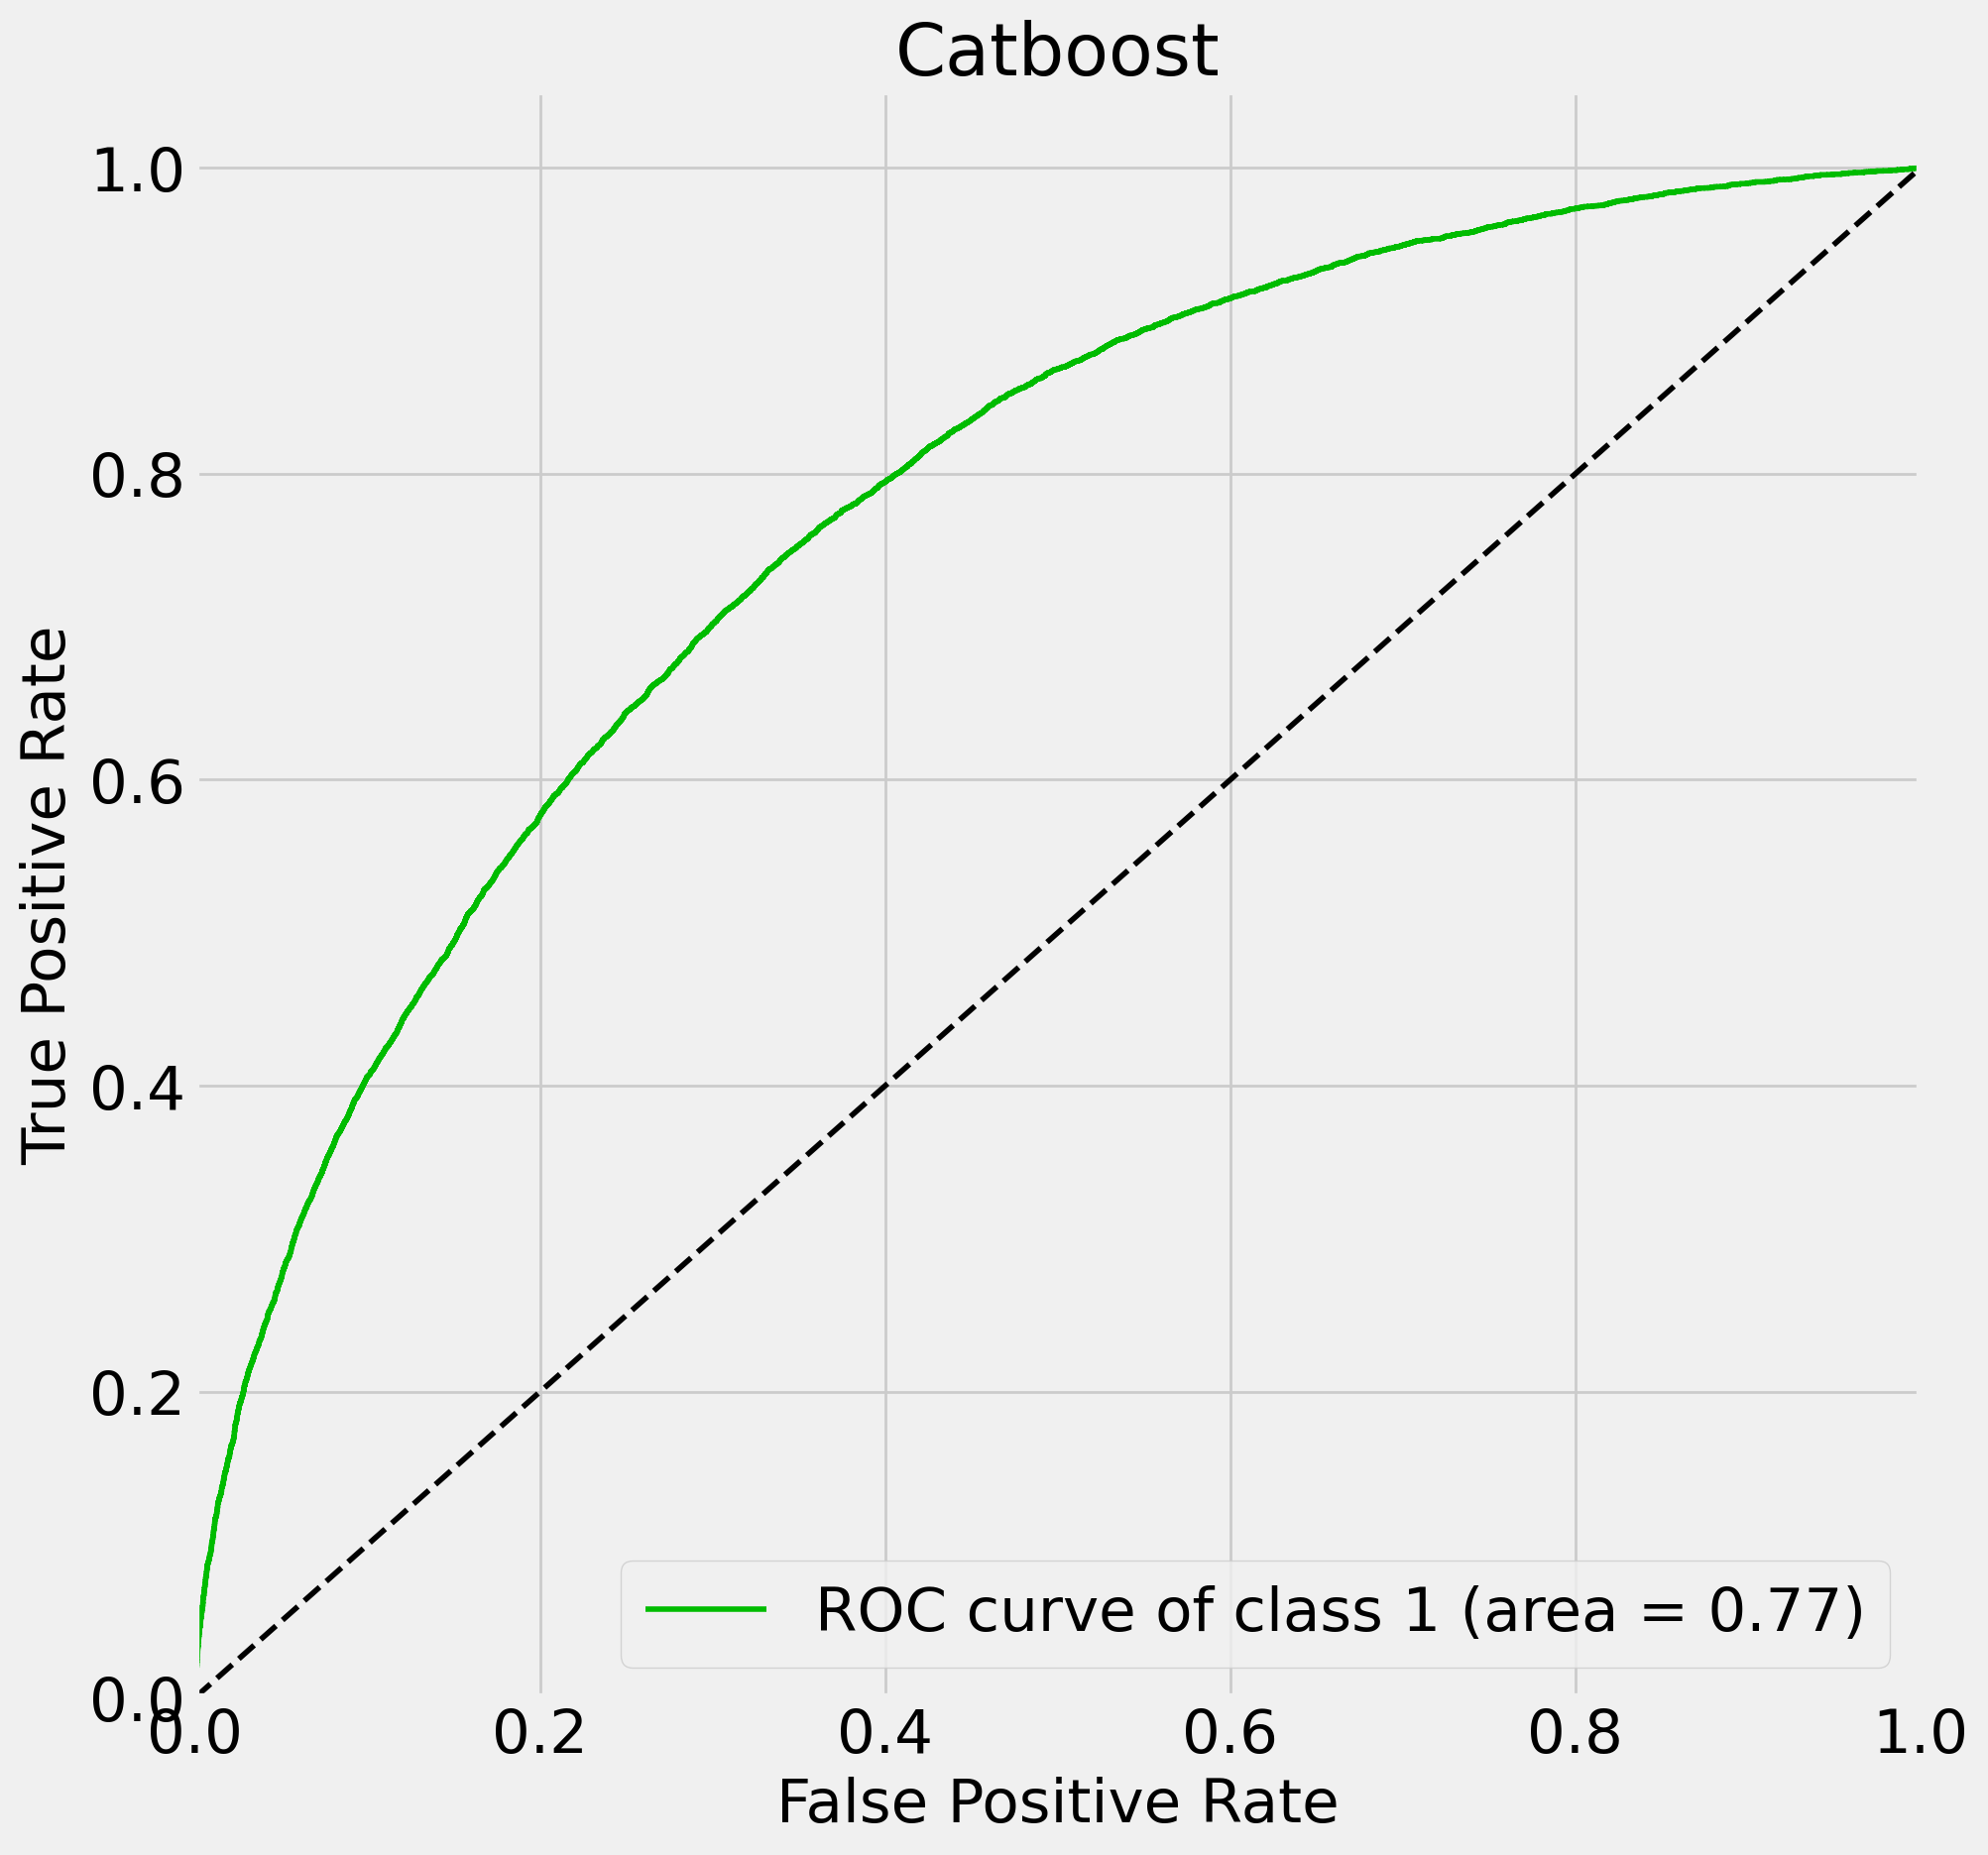

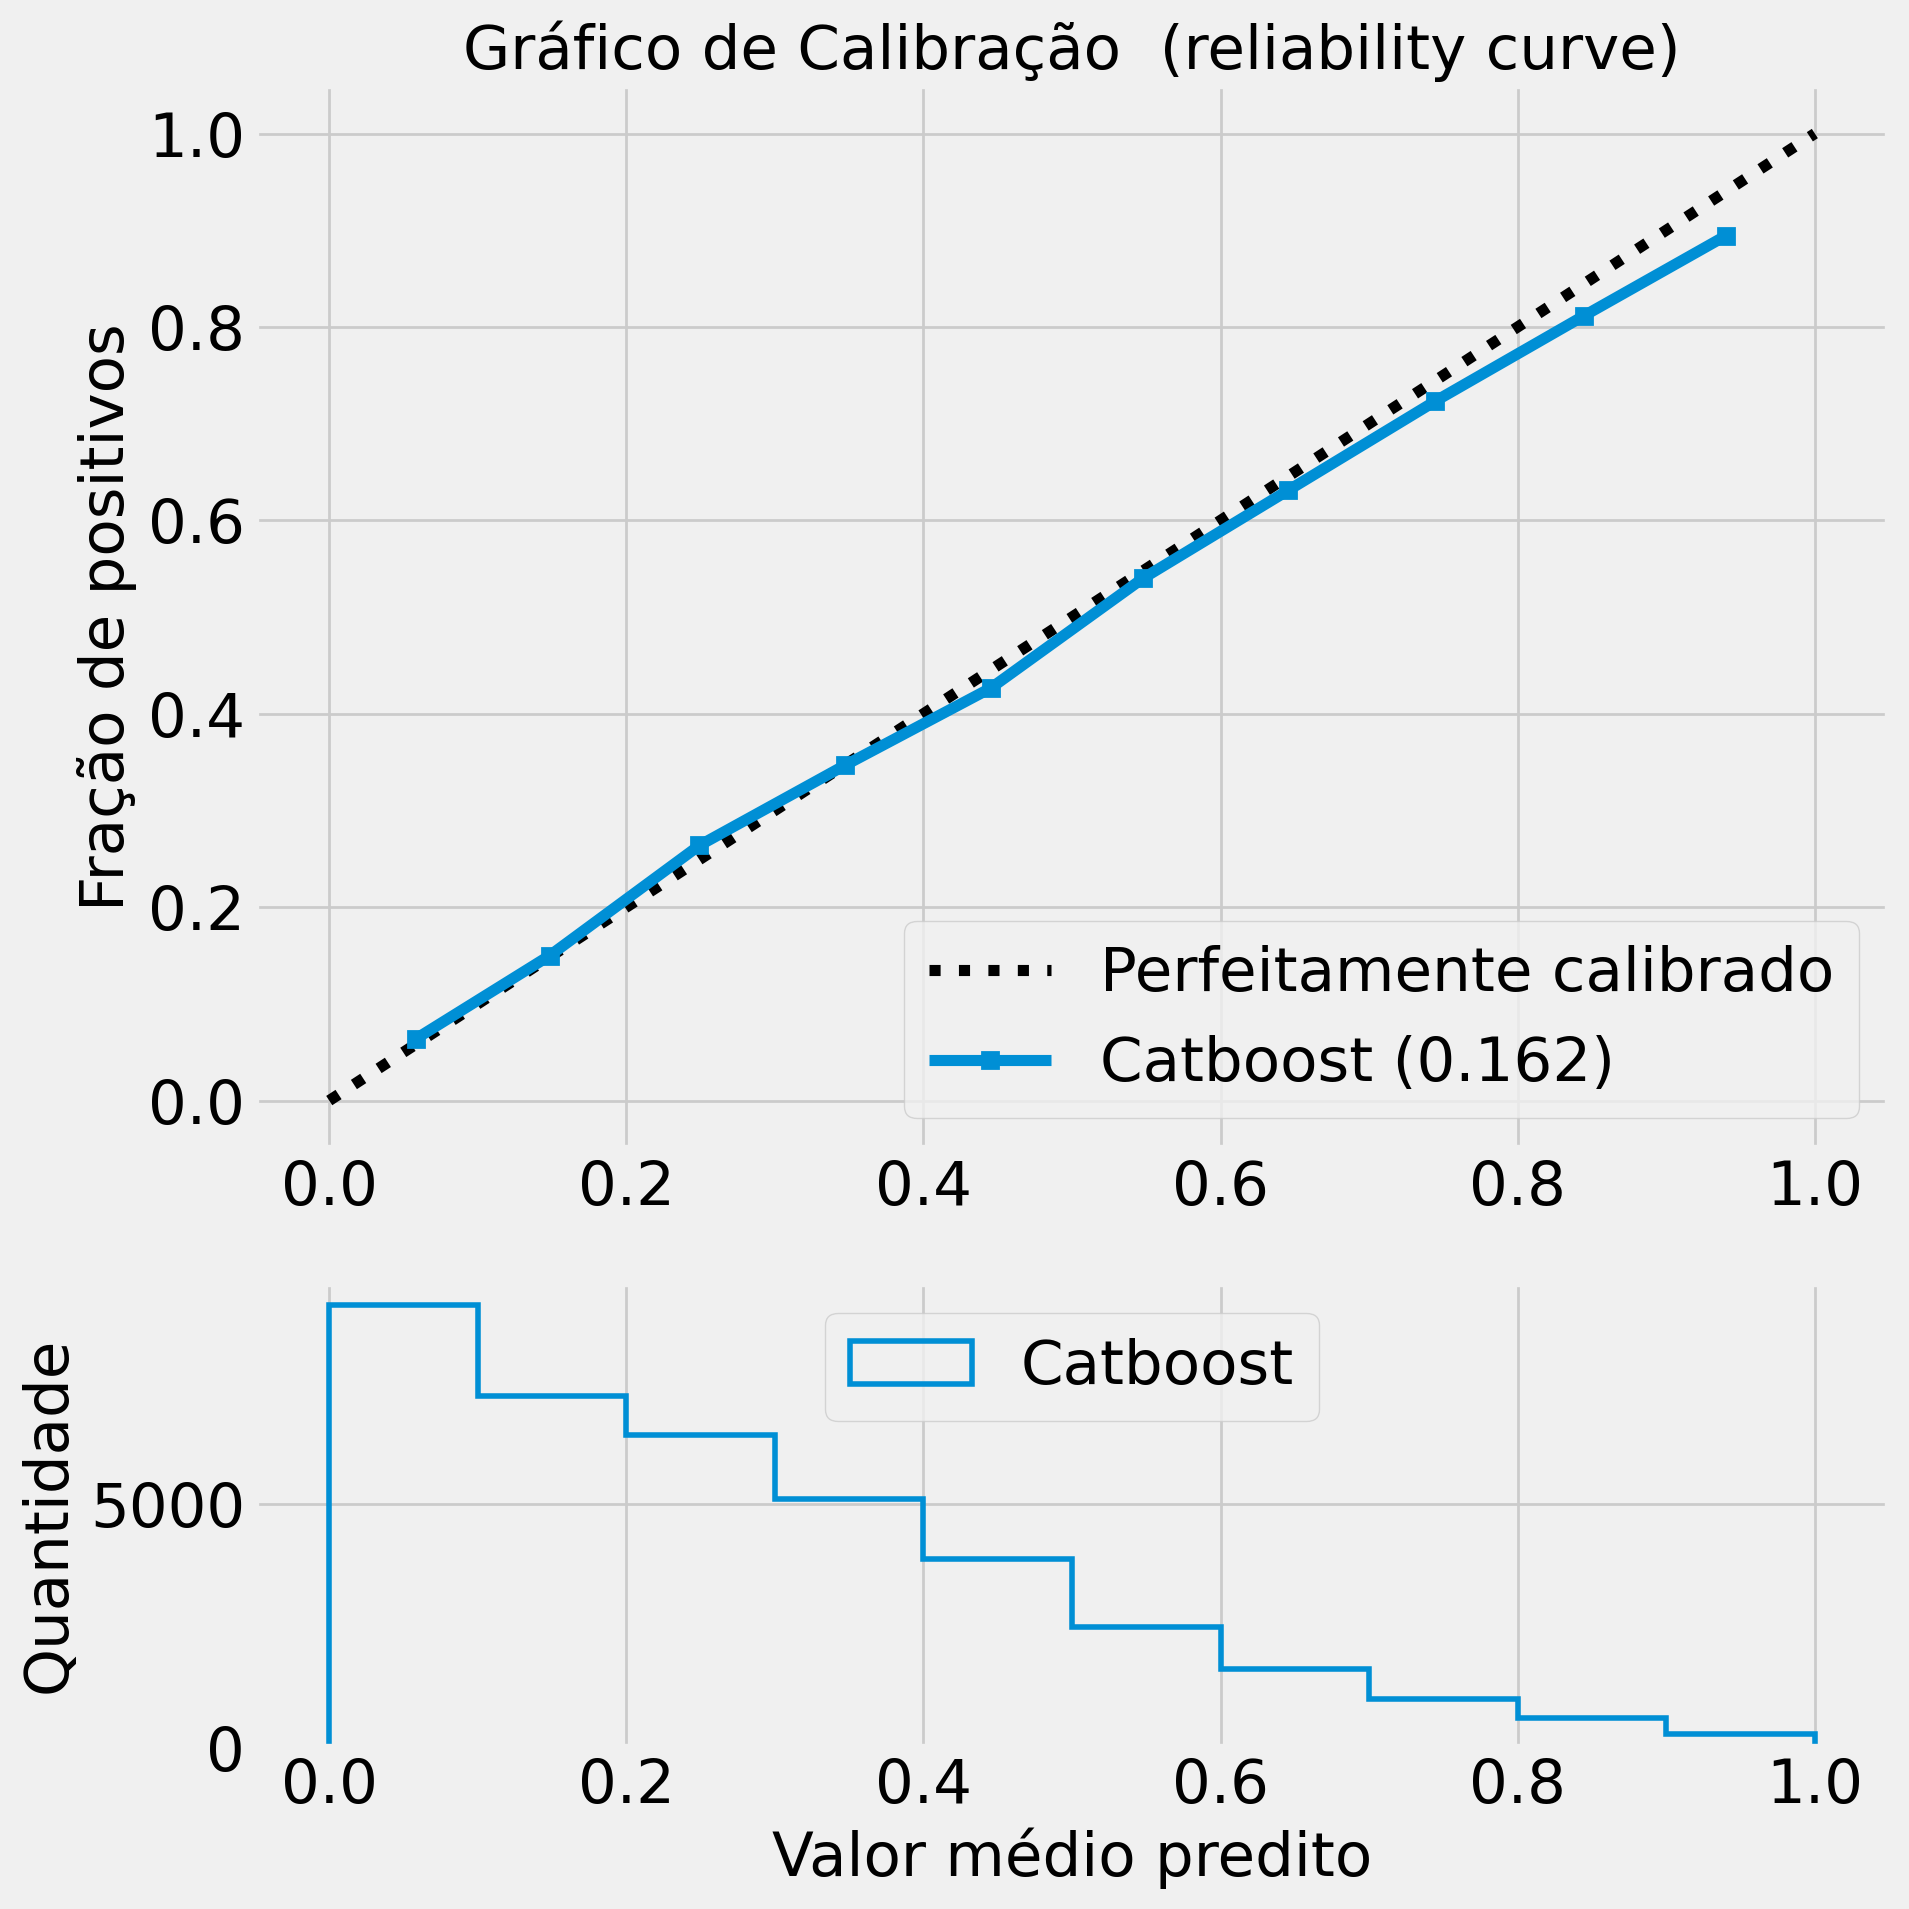

In [ ]:
runModel(clf_catboost, X_train, y_train, X_test, y_test, title="Catboost")

# **7. Não quero fazer nessa estrutrutura automatizada, como proceder?**

In [ ]:
!pip install catboost
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
! pip install lightgbm
import lightgbm as lgb
from catboost import CatBoostClassifier

**7.1 Random Forest**

In [ ]:
# Random Forest
# utilizaremos os mesmos hiperparâmetros obtidos na otimização anterior
rf = RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=1000,
                       random_state=42, verbose=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
prob_pos_rf = rf.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import classification_report
print('Random Forest Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_rf)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_rf)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_rf)))
print(classification_report(y_test, y_pred_rf))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   16.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   38.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   53.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    3.7s


Random Forest Model
Accuracy: 0.7636
Precision: 0.6634
Recall: 0.3226
AUC: 0.7728
              precision    recall  f1-score   support

           0       0.78      0.94      0.85     27033
           1       0.66      0.32      0.43     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.63      0.64     37601
weighted avg       0.75      0.76      0.73     37601



**7.2 Xgboost**

In [ ]:
# otimização de hiperparâmetros
# definindo o grid para possíveis valores dos hiperparâmetros

grid_xgboost = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [3, 6, 9, 12],
    'eta': [0.01, 0.03, 0.05, 0.1]
} # definimos o range dos hiperparâmetros a serem testados. É possível inserir outros hiperparâmetros para serem otimizados.
# é recomendável comparar os resultados dos hiperparâmetros otimizados com o algoritmo no default.

In [ ]:
xgboost_model = xgb.XGBClassifier(random_state=42) # realizamos a "chamada" do algoritmo, sem aplicar diretamente aos nossos dados
rs_cv_xgboost = RandomizedSearchCV(xgboost_model,  # realizamos a chamada do randomsearchCV, indicando que utilizaremos o algoritmo definido como 'catboost_rs'
            grid_xgboost,
            cv=3,
            n_iter=5,
            scoring = 'roc_auc',
            n_jobs = -1,
            verbose = 5,
            return_train_score = False,
            random_state=42)


In [ ]:
# aplicamos o random search com base nas definições do bloco de código anterior. No fit, especificamos que estamos aplicando ao conjunto de treinamento.
rs_cv_xgboost.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'eta': [0.01, 0.03, 0.05, 0.1],
                                        'max_depth': [3, 6, 9, 12],
                                        'n_estimators': [100, 500, 1000, 2000]},
                   random_state=42, scoring='roc_auc', verbose=5)

In [ ]:
rs_cv_xgboost.best_params_ # obtemos os hiperparâmetros otimizados

{'n_estimators': 500, 'max_depth': 6, 'eta': 0.01}

In [ ]:
# xgboost
clf_xgboost = xgb.XGBClassifier(n_estimators= 100, max_depth= 3, eta= 0.01, random_state=42) # "chamamos o algoritmo com os hiperparâmetros obtidos"
clf_xgboost.fit(X_train, y_train) # fazemos o fit no treino

y_pred_xgboost = clf_xgboost.predict(X_test) # obtemo as predições no teste
prob_pos_xgboost = clf_xgboost.predict_proba(X_test)[:,1] # obtemos as probabilidades preditas no teste

print('XGBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_xgboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_xgboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_xgboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_xgboost)))
print(classification_report(y_test, y_pred_xgboost))

XGBoost Model
Accuracy: 0.7494
Precision: 0.6746
Recall: 0.2095
AUC: 0.7534
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     27033
           1       0.67      0.21      0.32     10568

    accuracy                           0.75     37601
   macro avg       0.72      0.58      0.58     37601
weighted avg       0.73      0.75      0.70     37601



**7.3 LightGBM**

In [ ]:
# LightGBM
rs_params_lgbm = {
        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),
        'feature_fraction': (0.5, 0.8),
        'max_depth': (10, 13),
        'min_data_in_leaf': (90, 120),
        'num_leaves': (1200, 1550)
}
lgm_model = lgb.LGBMClassifier()
# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv_lgbm = RandomizedSearchCV(lgm_model, param_distributions=rs_params_lgbm, cv = 3, n_iter=50,verbose=1)


In [ ]:
rs_cv_lgbm.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=50,
                   param_distributions={'bagging_fraction': (0.5, 0.8),
                                        'bagging_frequency': (5, 8),
                                        'feature_fraction': (0.5, 0.8),
                                        'max_depth': (10, 13),
                                        'min_data_in_leaf': (90, 120),
                                        'num_leaves': (1200, 1550)},
                   verbose=1)

In [ ]:
rs_cv_lgbm.best_params_


{'num_leaves': 1200,
 'min_data_in_leaf': 120,
 'max_depth': 10,
 'feature_fraction': 0.5,
 'bagging_frequency': 5,
 'bagging_fraction': 0.8}

In [ ]:
lgbm_otimizado = lgb.LGBMClassifier(num_leaves= 1200,min_data_in_leaf= 120,
                                    max_depth= 10,feature_fraction= 0.8,
                                    bagging_frequency= 8,bagging_fraction= 0.8)


lgbm_otimizado.fit(X_train, y_train)


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 24659, number of negative: 63075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testin

LGBMClassifier(bagging_fraction=0.8, bagging_frequency=8, feature_fraction=0.8,
               max_depth=10, min_data_in_leaf=120, num_leaves=1200)

In [ ]:
# Aplicando aos dados de teste
y_pred_lgbm = lgbm_otimizado.predict(X_test)
prob_pos_lgbm = lgbm_otimizado.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import classification_report

print('LightGBM Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_lgbm)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_lgbm)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_lgbm)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_lgbm)))


print(classification_report(y_test, y_pred_lgbm))

# quero ver o desemepenho no treino também
# prob_pos_lgbm_treino = clf_lgbm.predict_proba(X_train)[:,1]
# print("AUC treino: {:.4f}".format(roc_auc_score(y_train, prob_pos_lgbm_treino)))


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
LightGBM Model
Accuracy: 0.7630
Precision: 0.6352
Recall: 0.3678
AUC: 0.7714
              precision    recall  f1-score   support

           0       0.7

**7.4 Catboost**

In [ ]:
# Catboost
# definimos o range dos hiperparâmetros a serem testados
grid = {"depth": [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],
                "iterations": [250, 100, 500, 1000],
                "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3],
                "l2_leaf_reg": [3, 1, 5, 10, 100],
                "border_count": [32, 5, 10, 20, 50, 100, 200]
               }
catboost_rs = CatBoostClassifier(eval_metric='Logloss', silent = True, random_seed=42,use_best_model= False) # realizamos a "chamada" do algoritmo, sem aplicar diretamente aos nossos dados

rs_cv_catboost = RandomizedSearchCV(catboost_rs, n_iter=20, cv=3, verbose=1, param_distributions=grid,n_jobs = -1) # realizamos a chamada do randomsearchCV, indicando que utilizaremos o algoritmo definido como 'catboost_rs'


In [ ]:
rs_cv_catboost.fit(X_train, y_train) # aplicamos o random search com base nas definições do bloco de código anterior. No fit, especificamos que estamos aplicando ao conjunto de treinamento.

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7dc2e96bad40>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'border_count': [32, 5, 10, 20, 50, 100,
                                                         200],
                                        'depth': [3, 1, 2, 6, 4, 5, 7, 8, 9,
                                                  10],
                                        'iterations': [250, 100, 500, 1000],
                                        'l2_leaf_reg': [3, 1, 5, 10, 100],
                                        'learning_rate': [0.03, 0.001, 0.01,
                                                          0.1, 0.2, 0.3]},
                   verbose=1)

In [ ]:
rs_cv_catboost.best_params_ # obtemos os hiperparâmetros selecionados a partir da otimização


{'learning_rate': 0.01,
 'l2_leaf_reg': 3,
 'iterations': 1000,
 'depth': 5,
 'border_count': 200}

In [ ]:
catboost_otimizado = CatBoostClassifier(eval_metric='Logloss', silent = True, random_seed=42,
                                        learning_rate= 0.01,
                                        l2_leaf_reg= 3,
                                        iterations= 1000,
                                        depth= 5,
                                        border_count= 200)
catboost_otimizado.fit(X_train, y_train)

In [ ]:
y_pred_catboost =catboost_otimizado.predict(X_test)
prob_pos_catboost = catboost_otimizado.predict_proba(X_test)[:,1]


from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import classification_report

print('Catboost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))

print(classification_report(y_test, y_pred_catboost))

Catboost Model
Accuracy: 0.7647
Precision: 0.6486
Recall: 0.3553
AUC: 0.7770
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     27033
           1       0.65      0.36      0.46     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.64      0.65     37601
weighted avg       0.75      0.76      0.74     37601



In [ ]:
# Comparando os resultados dos algoritmos

In [ ]:
# criando uma tabela com as métricas
col_names = ["Modelo", "Accuracy", "Precision", "Recall", "AUC(ROC)"] # definindo o cabeçalho

# definindo os valores
data = [["Random Forest", accuracy_score(y_test, y_pred_rf),precision_score(y_test, y_pred_rf),recall_score(y_test, y_pred_rf),roc_auc_score(y_test, prob_pos_rf)],
        ["XGBoost", accuracy_score(y_test, y_pred_xgboost),precision_score(y_test, y_pred_xgboost),recall_score(y_test, y_pred_xgboost),roc_auc_score(y_test, prob_pos_xgboost)],
        ["LightGBM", accuracy_score(y_test, y_pred_lgbm),precision_score(y_test, y_pred_lgbm),recall_score(y_test, y_pred_lgbm),roc_auc_score(y_test, prob_pos_lgbm)],
        ["Catboost", accuracy_score(y_test, y_pred_catboost),precision_score(y_test, y_pred_catboost),recall_score(y_test, y_pred_catboost),roc_auc_score(y_test, prob_pos_catboost)]]


In [ ]:
pd.set_option('display.float_format', lambda x: '%2f' % x) # tabela com três casas decimais

print('Resultados para conjunto de teste.')
df_results = pd.DataFrame(data, columns = col_names) # transformando os resultados do teste em um data.frame

# função para destacarmos os maiores valores em cada uma das métricas
def highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])] # estamos declarando que quando o tipo de dado for objeto, não aplicaremos o highlight
    else:
        is_max = s == s.max()
    return ['background: yellow' if cell else '' for cell in is_max]

df_results.style.apply(highlight_max)


Resultados para conjunto de teste.


,Modelo,Accuracy,Precision,Recall,AUC(ROC)
0,Random Forest,0.763597,0.663359,0.322578,0.772750
1,XGBoost,0.749422,0.674589,0.209500,0.753427
2,LightGBM,0.762958,0.635235,0.367808,0.771389
3,Catboost,0.764714,0.648644,0.355318,0.777029


**8. Seleção de variáveis com BORUTA**


In [ ]:
!pip install boruta # instalando o boruta. Ideal é que para a versão final do código, as instalações e importações sejam reunidas no início

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# criando estimador para o Boruta. Por padrão, utilizamos o RandomForestClassifier, porém é possível alterar para outros algoritmos, como o lgbm
forest = RandomForestClassifier(
   n_jobs = -1,
   max_depth = 5
)

boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 100 # número de iterações. quanto maior, mais demorado
)

# parametrizando para o conjunto de treino
boruta.fit(np.array(X_train), np.array(y_train)) # aplicamos o boruta no treino

# resultados
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

ModuleNotFoundError: ignored

In [ ]:
# Modelo com Boruta - Selecionado as variáveis preditoras
X_train_boruta = X_train[['numAge', 'bmi', 'tchol', 'sbp', 'htn', 'smoking', 't2d', 'gender', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']]

X_test_boruta = X_test[['numAge', 'bmi', 'tchol', 'sbp', 'htn', 'smoking', 't2d', 'gender', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']]

print('Shape sem boruta', X_train.shape, X_test.shape)
print('Shape com boruta', X_train_boruta.shape, X_test_boruta.shape)

# verificamos que o boruta removeu somente uma variável preditora

Shape sem boruta (87734, 12) (37601, 12)
Shape com boruta (87734, 11) (37601, 11)


**9. Catboost com BORUTA**

Utilizamos o Catboost, pois foi o algoritmo com melhor desempenho entre os quatro testados

In [ ]:
catboost_otimizado_boruta = CatBoostClassifier(eval_metric='Logloss', silent = True, random_seed=42,
                                        learning_rate= 0.01,
                                        l2_leaf_reg= 3,
                                        iterations= 1000,
                                        depth= 5,
                                        border_count= 200)
catboost_otimizado_boruta.fit(X_train_boruta, y_train)

In [ ]:
# catboost

y_pred_catboost_boruta = catboost_otimizado_boruta.predict(X_test_boruta)
prob_pos_catboost_boruta = catboost_otimizado_boruta.predict_proba(X_test_boruta)[:,1]

print('XGBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost_boruta)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost_boruta)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost_boruta)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost_boruta)))

print(classification_report(y_test, y_pred_xgboost))

XGBoost Model
Accuracy: 0.7651
Precision: 0.6500
Recall: 0.3558
AUC: 0.7769
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     27033
           1       0.65      0.34      0.45     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.64      0.65     37601
weighted avg       0.75      0.76      0.74     37601



**Comparando os resultados do teste c/ e s/ BORUTA para o catboost**

In [ ]:
print("###### CATBOOST SEM BORUTA #####")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))

print(classification_report(y_test, y_pred_catboost))

print("\n", "###### CATBOOST COM BORUTA #####")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost_boruta)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost_boruta)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost_boruta)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost_boruta)))

print(classification_report(y_test, y_pred_catboost))

###### CATBOOST SEM BORUTA #####
Accuracy: 0.7647
Precision: 0.6486
Recall: 0.3553
AUC: 0.7770
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     27033
           1       0.65      0.36      0.46     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.64      0.65     37601
weighted avg       0.75      0.76      0.74     37601


 ###### CATBOOST COM BORUTA #####
Accuracy: 0.7651
Precision: 0.6500
Recall: 0.3558
AUC: 0.7769
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     27033
           1       0.65      0.36      0.46     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.64      0.65     37601
weighted avg       0.75      0.76      0.74     37601



**Obtendo as predições e os riscos para os pacientes do teste**

In [ ]:
X_test # verificando o conjuto X de teste

,numAge,bmi,tchol,sbp,htn,smoking,t2d,gender,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White
0,-0.765511,1.387139,-1.091504,-0.891419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,-0.336487,-0.206144,-0.348660,-1.397151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,1.915894,1.614750,0.124058,-0.986243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,-0.658255,0.021468,-0.990207,-0.701769,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
4,1.701382,0.249080,-0.449957,0.688994,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
37596,-0.336487,2.297585,-0.956441,1.163118,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
37597,-1.194536,2.980421,0.090292,-0.638553,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
37598,2.130407,-1.116590,0.866901,1.257942,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
37599,-0.336487,0.249080,-0.078536,1.795282,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
desfecho = pd.DataFrame({'desfecho':y_test}) # verificando o conjunto y de teste
desfecho.head()

,desfecho
0,0
1,1
2,0
3,1
4,1


In [ ]:
desfecho_predito = pd.DataFrame({'desfecho_predito':y_pred_catboost_boruta})
desfecho_predito.head()

,desfecho_predito
0,0
1,0
2,0
3,0
4,1


In [ ]:
prob_predita = pd.DataFrame({'prob_predita':prob_pos_catboost_boruta})
prob_predita.head()

,prob_predita
0,0.063465
1,0.052826
2,0.174498
3,0.217745
4,0.651217


In [ ]:
pd.concat([X_test, desfecho, desfecho_predito, prob_predita], axis=1) # juntado o X_test, o desfecho, a predição e a probabilidade predita

,numAge,bmi,tchol,sbp,htn,smoking,t2d,gender,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White,desfecho,desfecho_predito,prob_predita
0,-0.765511,1.387139,-1.091504,-0.891419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0.063465
1,-0.336487,-0.206144,-0.348660,-1.397151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.052826
2,1.915894,1.614750,0.124058,-0.986243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0.174498
3,-0.658255,0.021468,-0.990207,-0.701769,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.217745
4,1.701382,0.249080,-0.449957,0.688994,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,1,0.651217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37596,-0.336487,2.297585,-0.956441,1.163118,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,1,0.547597
37597,-1.194536,2.980421,0.090292,-0.638553,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.231499
37598,2.130407,-1.116590,0.866901,1.257942,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0,1,0.545894
37599,-0.336487,0.249080,-0.078536,1.795282,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.488874


**10. Valores de Shapley**

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 18.6 MB/s eta 0:00:00


In [ ]:
import shap

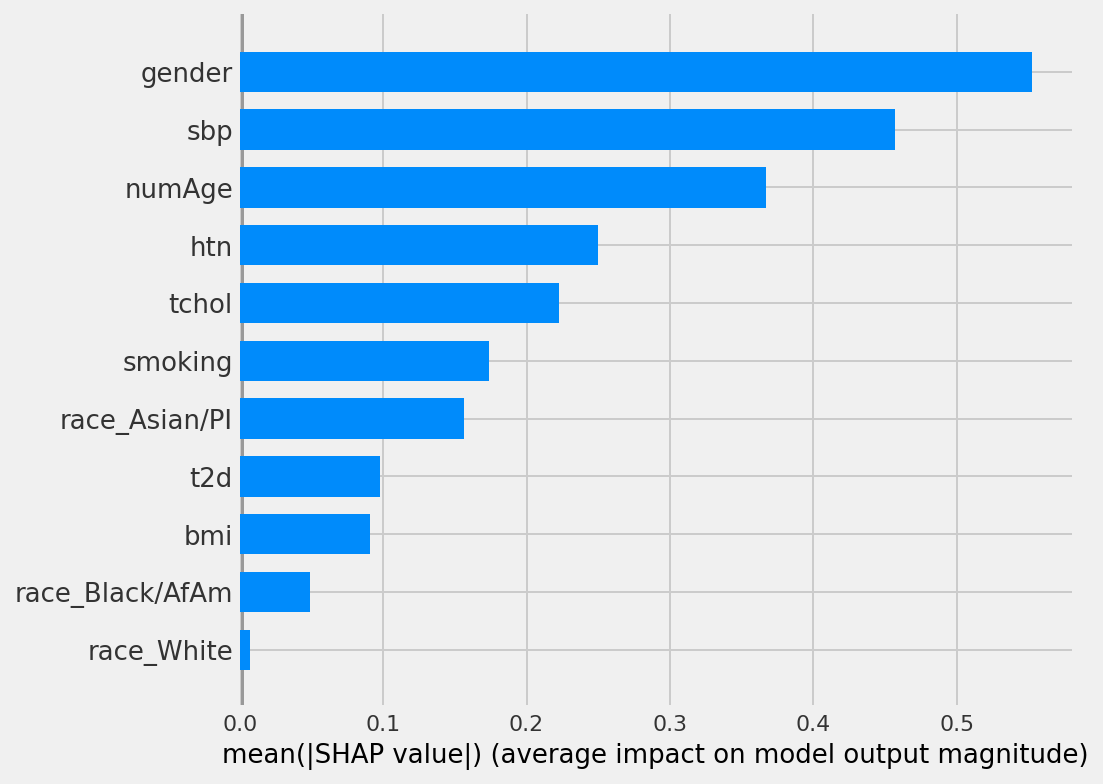

In [ ]:
# resultados no teste
shap_values_test = shap.TreeExplainer(catboost_otimizado_boruta).shap_values(X_test_boruta)
shap.summary_plot(shap_values_test, X_test_boruta, plot_type="bar")

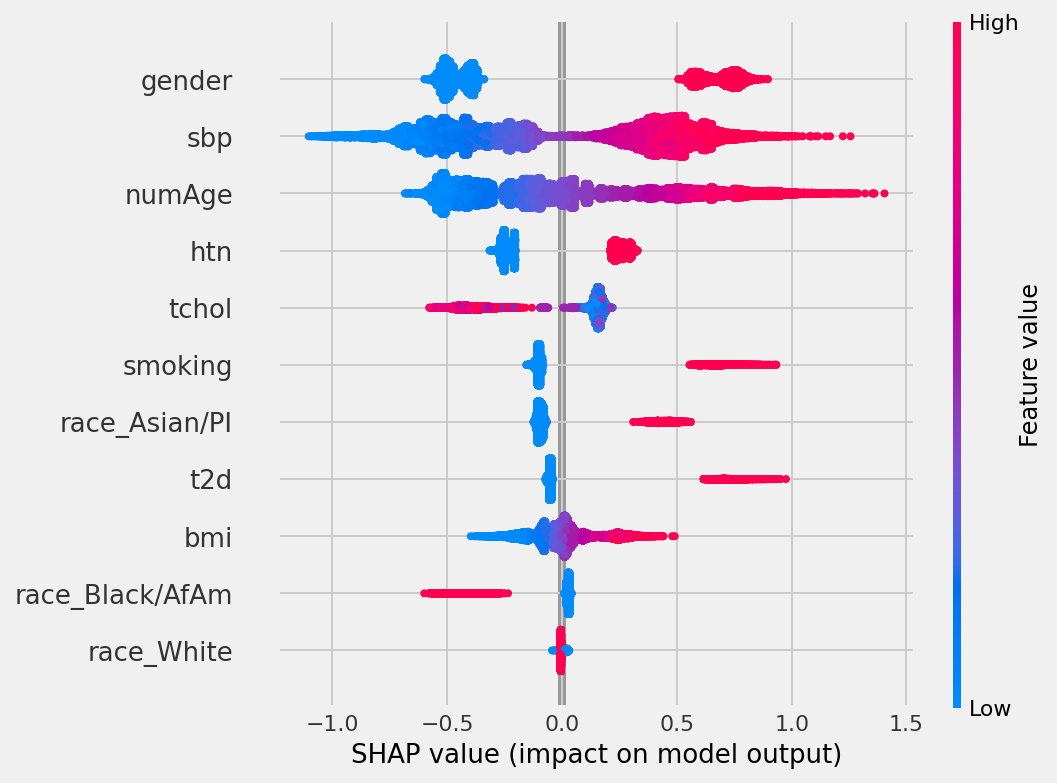

In [ ]:
shap.summary_plot(shap_values_test, X_test_boruta)

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(catboost_otimizado_boruta)
shap_values = explainer.shap_values(X_test_boruta)

i = 0
# Inserindo os dados do paciente
print('Desfecho do paciente:', y_test[i])
print('Predição:', y_pred_xgboost_boruta[i])

# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_boruta.iloc[i,:])

Desfecho do paciente: 0
Predição: 0


**11. Salvando e carregando o modelo**

Finalizamos a análise e salvaremos o algoritmo para alguma aplicação futura

In [ ]:
import joblib
import os

In [ ]:
def save_model(model, path):
    """Função para salvar o modelo localmente.
    Args:
        model: Modelo para salvar
        path (str): caminho para salvar o modelo
    """
    if os.path.dirname(path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        joblib.dump(model, f)

In [ ]:
# salvando o modelo catboost otimizado com seleção de variáveis feita pelo boruta
save_model(catboost_otimizado_boruta, 'models/catboost_otimizado_boruta.pkl')

**Carregando um modelo desenvolvido previamente**

In [ ]:
def read_model(path):
    """Função para ler um modelo salvo
    Args:
        path (str): caminho do modelo salvo
    Returns:
        file: modelo carregado
    """
    with open(path, "rb") as f:
        file = joblib.load(f)

    return file

In [ ]:
# alterar caminho e nome do modelo conforme necessidades
modelo_carregado = read_model('models/catboost_otimizado_boruta.pkl')

In [ ]:
# obtendo os hiperparâmetros do modelo
modelo_carregado.get_params()

{'iterations': 1000,
 'learning_rate': 0.01,
 'depth': 5,
 'l2_leaf_reg': 3,
 'border_count': 200,
 'random_seed': 42,
 'silent': True,
 'eval_metric': 'Logloss'}

In [ ]:
# revalidando os resultados de teste
# em uma aplicação real, após as etapas de pré-processamento nos dados novos,
# faríamos as predições nos novos indivíduos após o carregamento de um modelo pré-treinado
resultado = modelo_carregado.score(X_test_boruta, y_test) # padrão da função é a acurácia. Aqui utilizamos somente para demonstrar e comparar os valores como exemplo
resultado

0.7650860349458791